Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [1]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2

In [2]:
batch_size = 256
learning_rate = 1e-3
num_epochs = 300
latent_dim = 3

mnist_class_anomaly = 4
kernels = 8
fuzzy_rules_count = 10

prefix = f"fuzzy_fuzzy_svdd"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [3]:
def norm_and_transform(x):
    nimg = x.view(-1, 28, 28)
    nimg = torch.clamp(nimg, 0, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, 0, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomRotation(15, fill=0), 
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), fill=0), 
    #transforms.RandomCrop(size=26),
    #transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [4]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54158

загружаем тестовую выборку

In [5]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [6]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

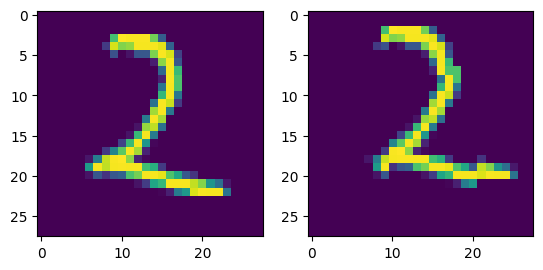

In [7]:
for data,_ in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    break

## Модель

In [8]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels, fuzzy_rules_count):
        super(Encoder, self).__init__()
                
        self.latent = nn.Sequential(
            nn.Conv2d(1, kernels, kernel_size=4), 
            nn.BatchNorm2d(kernels), 
            nn.SiLU(),
            nn.Conv2d(kernels, 2*kernels, kernel_size=4), 
            nn.BatchNorm2d(2*kernels), 
            nn.SiLU(),
            nn.Conv2d(2*kernels, 4*kernels, kernel_size=4), 
            nn.BatchNorm2d(4*kernels), 
            nn.SiLU(),
            nn.Conv2d(4*kernels, 8*kernels, kernel_size=4), 
            nn.BatchNorm2d(8*kernels), 
            nn.SiLU(),
            nn.Conv2d(8*kernels, 16*kernels, kernel_size=4), 
            nn.BatchNorm2d(16*kernels), 
            nn.SiLU(),
            nn.Flatten(),
            nn.Linear(16*kernels*13*13, latent_dim)
        )

        rscale = 1
        initial_centroids = 2 * rscale * (0.5- np.random.random((fuzzy_rules_count, latent_dim)))
        initial_scales = rscale * np.ones((fuzzy_rules_count, latent_dim))
        self.fuzzy = nn.Sequential(
            FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=True)
        )
        self.register_buffer('centroid', torch.rand(latent_dim))
        

         
    def forward(self, x):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        
        out = self.latent(x)
        
        fz = self.fuzzy(out).sum(-1)

        return out, fz

In [9]:
inp = torch.rand(10, 1, 28, 28)
m = Encoder(latent_dim= latent_dim, kernels=16, fuzzy_rules_count=fuzzy_rules_count)
mu, fz = m.forward(inp)
fz.shape

torch.Size([10])

## Обучение

In [10]:
model = Encoder(latent_dim=latent_dim, fuzzy_rules_count=fuzzy_rules_count, kernels=kernels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 239,941


Encoder(
  (latent): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU()
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU()
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=21632, out_features=3, bias=True)
  )
  (fuzzy): Sequential(
    (0): Fu

In [11]:
#optimizer = torch.optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=learning_rate)
#optimizer_d = torch.optim.Adam(model.delta_decoder.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
#sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

In [12]:
def compute_fuzzy_loss(fz):
    return (1 - fz).square().mean()#(1 - fz.sum(-1).clamp(max=1)).square().mean() #(0.999 - (tops[:,0]+tops[:,1]).clamp(max=0.999)).mean() + tops[:, 2].clamp(min=0.001).mean()

In [13]:
def compute_fshape_loss(fuzzy_layer):
    target_volume = 100
    eigens = fuzzy_layer.get_transformation_matrix_eigenvals().real.sum(-1)
    #fz_volume = (target_volume - eigens).abs().clamp(max = target_volume).square()
    #fz_volume = fz_volume.mean()
    
    return -eigens.mean()#-fz_volume#

In [14]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [15]:
def get_arate(inp):
    _, fz = model.forward(inp)
    return fz.cpu().numpy()

In [16]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    #model.fuzzy[0].requires_grad = False
    #model.fuzzy[0].set_requires_grad_rot(False)
    #model.fuzzy[0].set_requires_grad_scales(False)
    #model.fuzzy[0].set_requires_grad_centroids(False)
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  

        _, fz = model.forward(adata)  
        
        loss_fz = compute_fuzzy_loss(fz)
        shape_loss = compute_fshape_loss(model.fuzzy[0])

        #ev_loss = keep_eigenvals_positive_loss(model.fuzzy[0])
        #if ev_loss.item() > 0:
        #    ev_loss.backward(retain_graph=True)
        
        shape_loss.backward(retain_graph=True)
        loss_fz.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.12)    
        optimizer.step()  
        
        if sched is not None:
            sched.step()
        
    if writer is not None:
        writer.add_scalar('FSVDD/LR', get_lr(optimizer), global_step=epoch)
        writer.add_scalar('FSVDD/Train/Loss/Fuzzy', loss_fz.item(), global_step=epoch)
        writer.add_scalar('FSVDD/Train/Loss/Shape', shape_loss.item(), global_step=epoch)
#        writer.add_scalar('FSVDD/Train/Loss/EV', ev_loss.item(), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [17]:
def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 
    test_fz_loss = 0
    
    lab_true = []
    lab_pred = []
    centroids = model.fuzzy[0].get_centroids().detach().cpu().numpy()
    #rads = model.fuzzy[0].get_transformation_matrix_eigenvals().real.min(-1).values
    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = get_arate(data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)
            
            mu, fz = model.forward(data)  
        
            loss_fz = compute_fuzzy_loss(fz)
            
            embedings.append(mu.cpu().numpy())
            labels_expected.append((target == mnist_class_anomaly).cpu().numpy())

            test_fz_loss += loss_fz.item()
            

    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    if epoch % 3 == 1:
        plt.figure(figsize=(18, 6))

        R, C = 1, 3

        plt.subplot(R, C, 1)
        plt.title("MNIST XY")
        plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='Set2', s=4)
        plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)
        
        #plt.scatter(centroids_resd[:, 0],      centroids_resd[:, 1], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        plt.subplot(R, C, 2)
        plt.title("MNIST XZ")
        plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='Set2', s=4)
        plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)
        #plt.scatter(centroids_resd[:, 0], centroids_resd[:, 2], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        #for i in range(fuzzy_rules_count):
        #    plt.Circle(( centroids[i, 0], centroids[i, 1] ), 1/rads[i] )

        plt.show()
    
    test_fz_loss /= len(dataloader)
    
    print(f'[{cur_step}] Reconstruction loss: AUC {roc_auc:.4f} FZ {test_fz_loss:.4f}')
    
    if writer is not None:
        writer.add_scalar('FSVDD/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('FSVDD/Test/Loss/Fuzzy', test_fz_loss, global_step=epoch)

In [18]:
#model.fuzzy[0].get_transformation_matrix_eigenvals()

In [19]:
prev_updates = 0

[212] Reconstruction loss: AUC 0.4895 FZ 0.1202


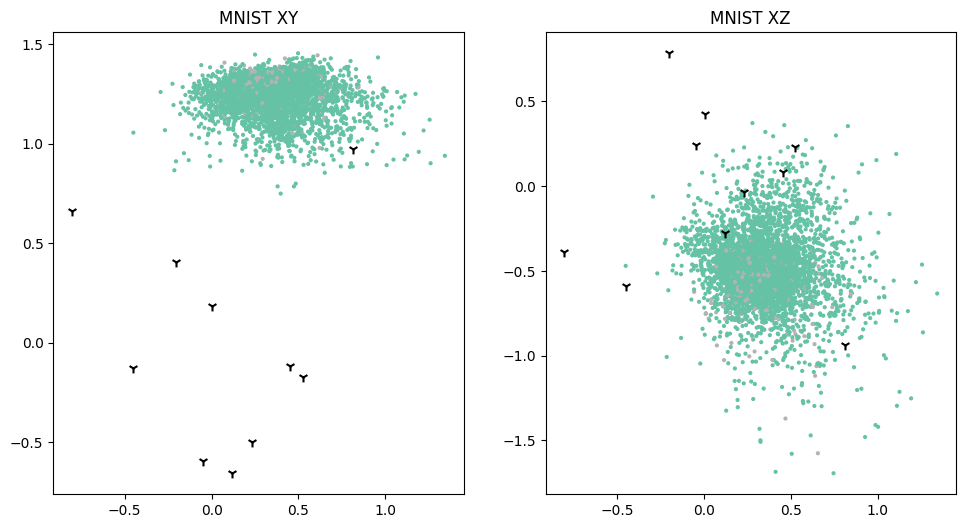

[424] Reconstruction loss: AUC 0.3879 FZ 0.0080
[636] Reconstruction loss: AUC 0.5143 FZ 0.0043
[848] Reconstruction loss: AUC 0.3980 FZ 0.0028


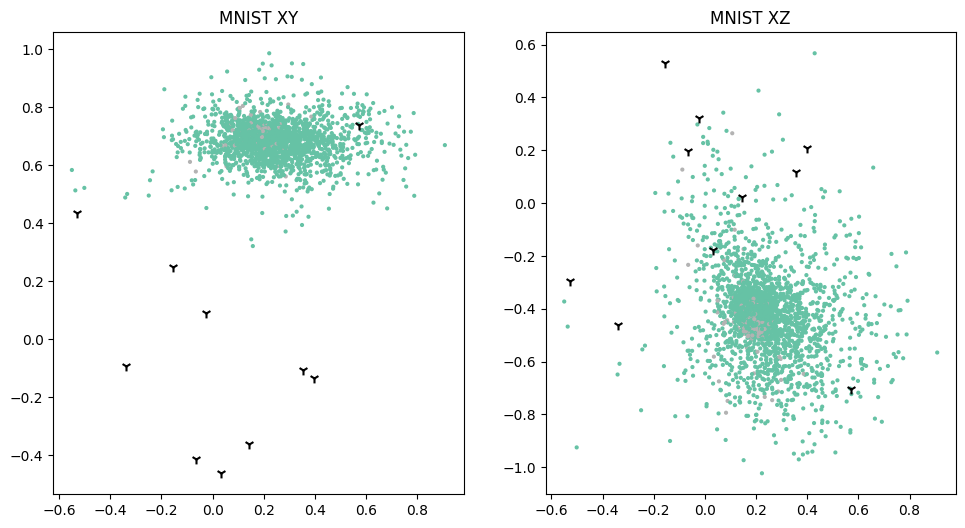

[1060] Reconstruction loss: AUC 0.2929 FZ 0.0023
[1272] Reconstruction loss: AUC 0.5246 FZ 0.0068
[1484] Reconstruction loss: AUC 0.5146 FZ 0.0028


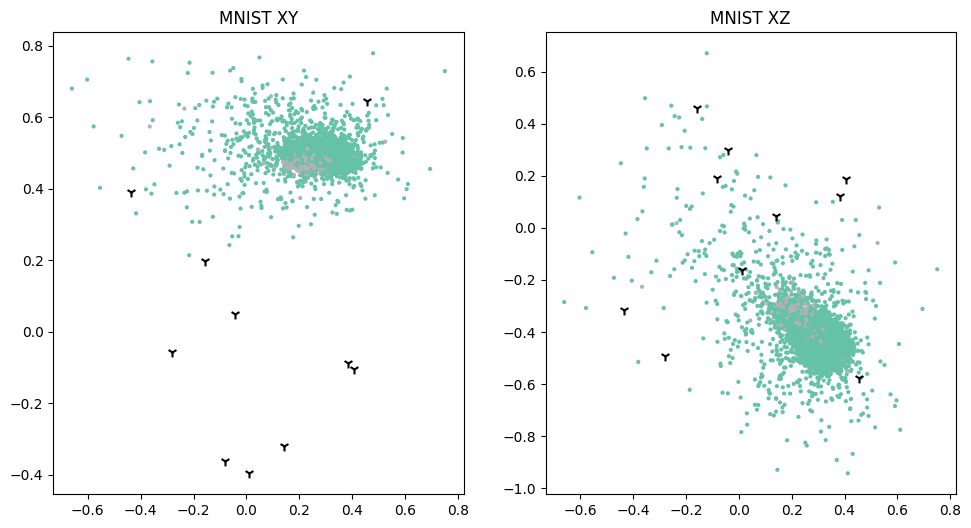

[1696] Reconstruction loss: AUC 0.5349 FZ 0.0029
[1908] Reconstruction loss: AUC 0.4484 FZ 0.0051
[2120] Reconstruction loss: AUC 0.7270 FZ 0.0055


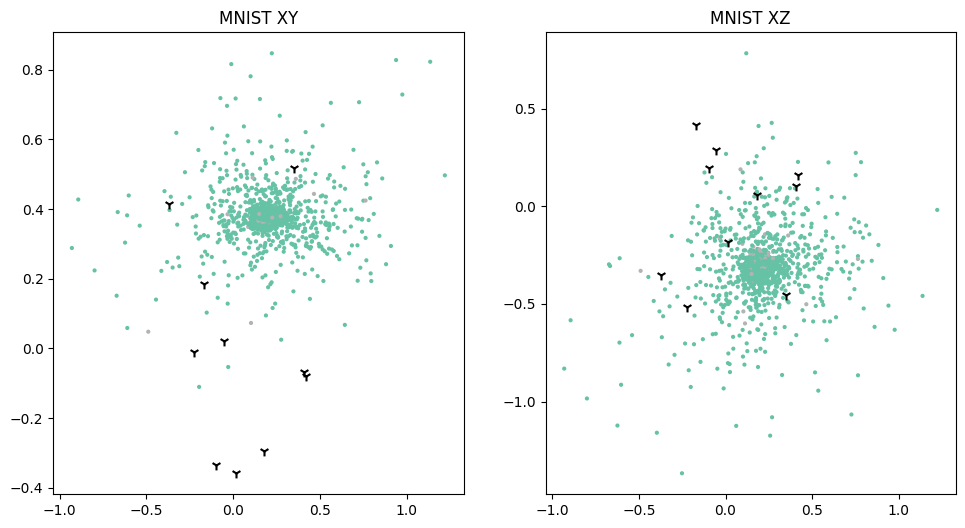

[2332] Reconstruction loss: AUC 0.4444 FZ 0.0053
[2544] Reconstruction loss: AUC 0.5218 FZ 0.0021
[2756] Reconstruction loss: AUC 0.4019 FZ 0.0060


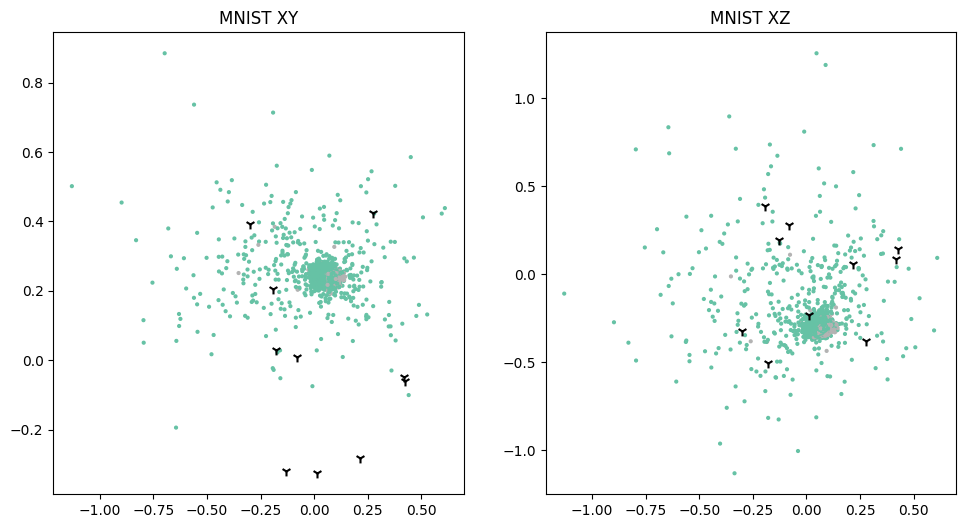

[2968] Reconstruction loss: AUC 0.5280 FZ 0.0037
[3180] Reconstruction loss: AUC 0.3688 FZ 0.0040
[3392] Reconstruction loss: AUC 0.7016 FZ 0.0028


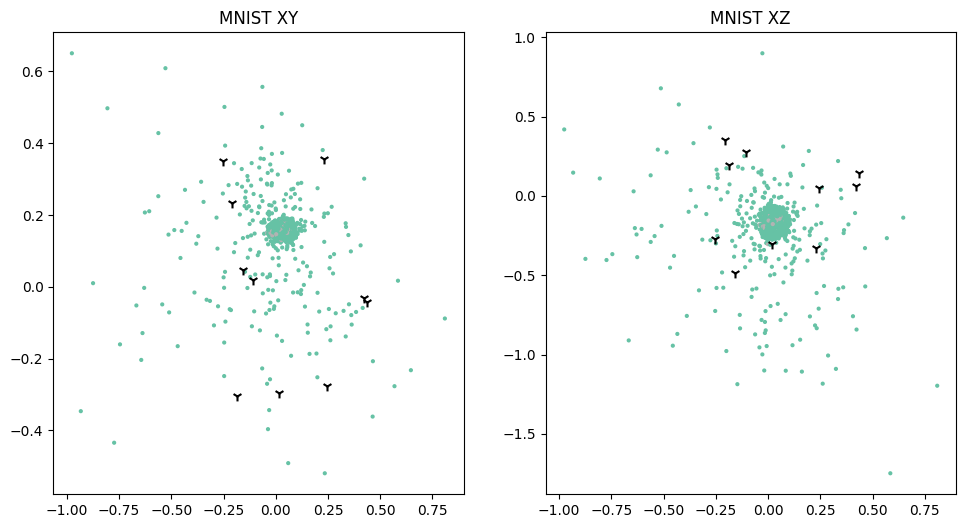

[3604] Reconstruction loss: AUC 0.5515 FZ 0.0046
[3816] Reconstruction loss: AUC 0.4023 FZ 0.0026
[4028] Reconstruction loss: AUC 0.3057 FZ 0.0029


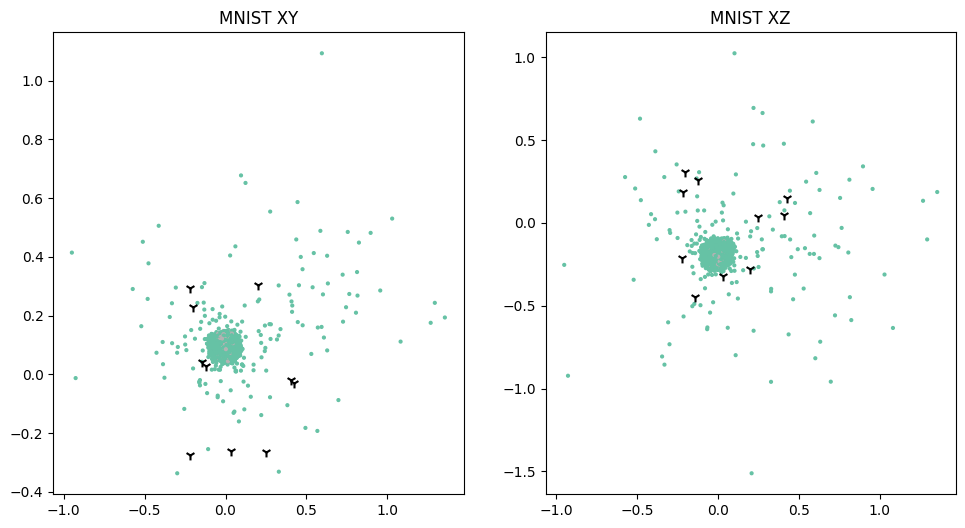

[4240] Reconstruction loss: AUC 0.5010 FZ 0.0043
[4452] Reconstruction loss: AUC 0.4174 FZ 0.0040
[4664] Reconstruction loss: AUC 0.2058 FZ 0.0053


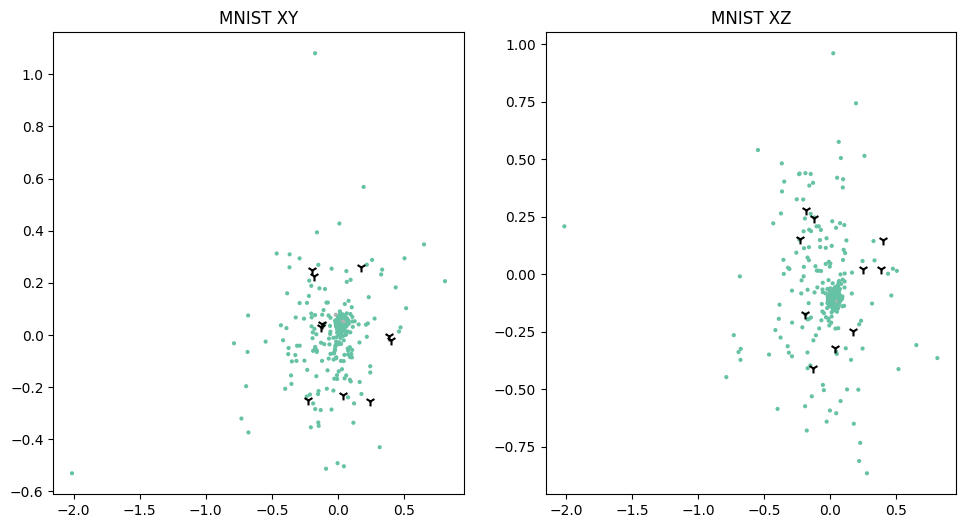

[4876] Reconstruction loss: AUC 0.4920 FZ 0.0030
[5088] Reconstruction loss: AUC 0.3698 FZ 0.0035
[5300] Reconstruction loss: AUC 0.4542 FZ 0.0041


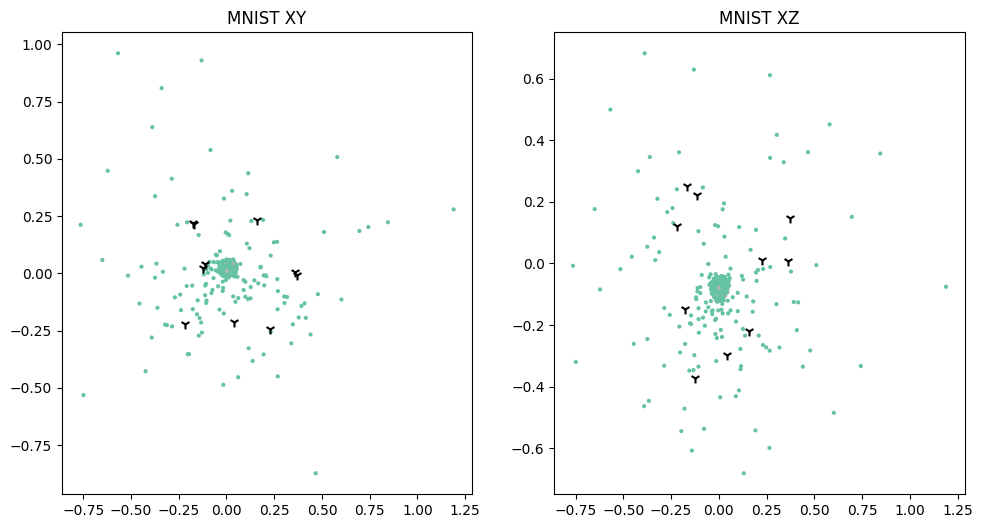

[5512] Reconstruction loss: AUC 0.4797 FZ 0.0030
[5724] Reconstruction loss: AUC 0.6118 FZ 0.0045
[5936] Reconstruction loss: AUC 0.3833 FZ 0.0049


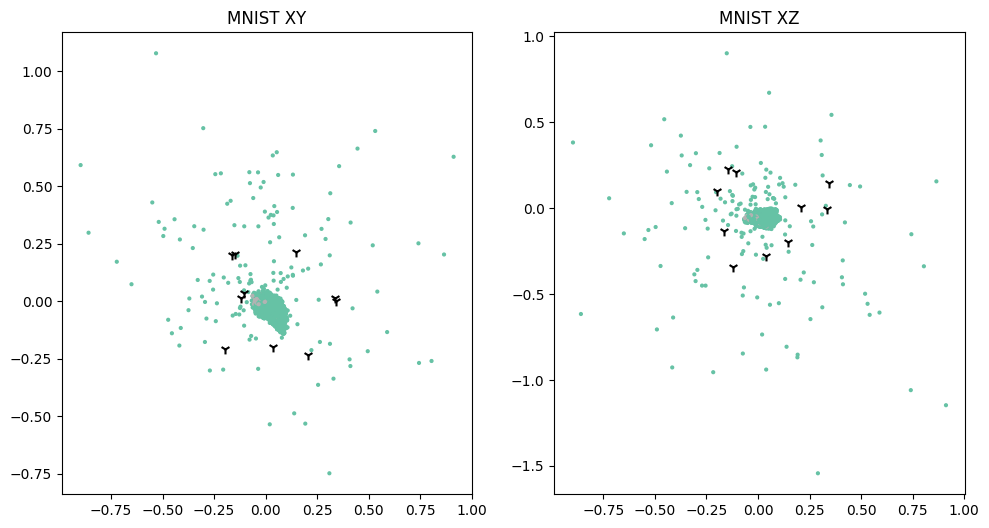

[6148] Reconstruction loss: AUC 0.5051 FZ 0.0057
[6360] Reconstruction loss: AUC 0.4635 FZ 0.0038
[6572] Reconstruction loss: AUC 0.4202 FZ 0.0127


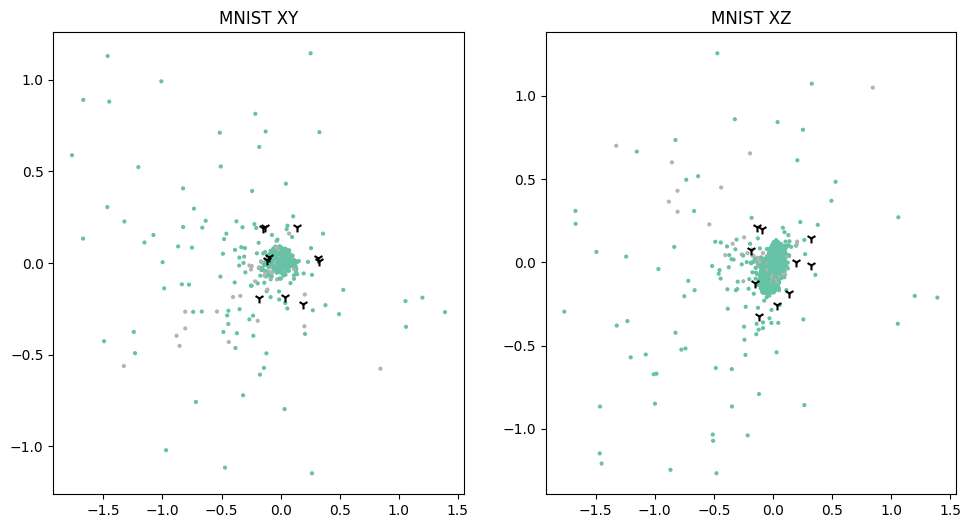

[6784] Reconstruction loss: AUC 0.4419 FZ 0.0078
[6996] Reconstruction loss: AUC 0.4715 FZ 0.0083
[7208] Reconstruction loss: AUC 0.4212 FZ 0.0030


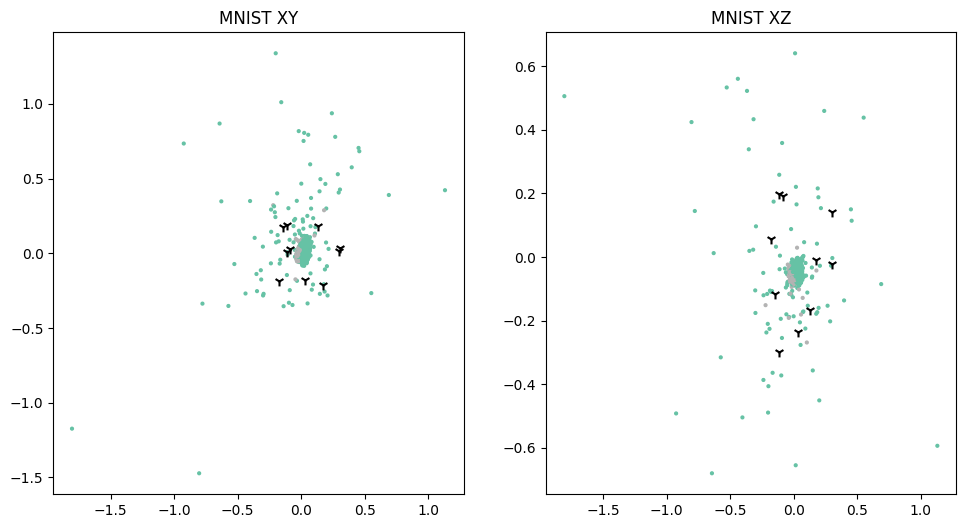

[7420] Reconstruction loss: AUC 0.6905 FZ 0.0041
[7632] Reconstruction loss: AUC 0.3363 FZ 0.0068
[7844] Reconstruction loss: AUC 0.6529 FZ 0.0061


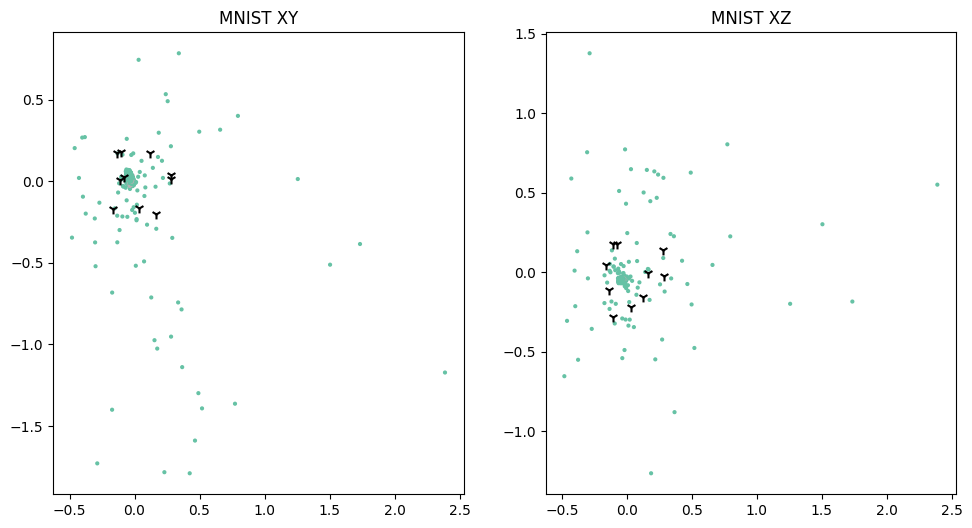

[8056] Reconstruction loss: AUC 0.3745 FZ 0.0047
[8268] Reconstruction loss: AUC 0.5925 FZ 0.0079
[8480] Reconstruction loss: AUC 0.4735 FZ 0.0059


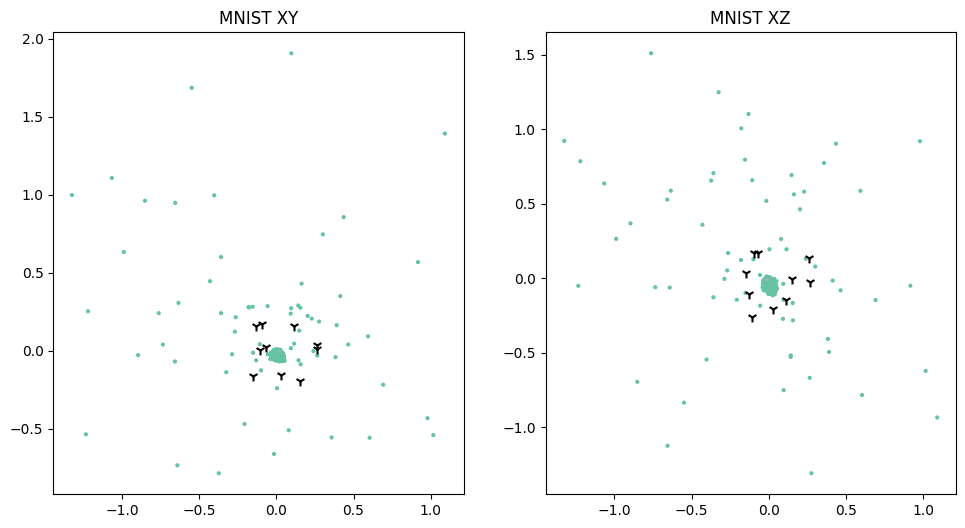

[8692] Reconstruction loss: AUC 0.3520 FZ 0.0049
[8904] Reconstruction loss: AUC 0.4821 FZ 0.0078
[9116] Reconstruction loss: AUC 0.4204 FZ 0.0084


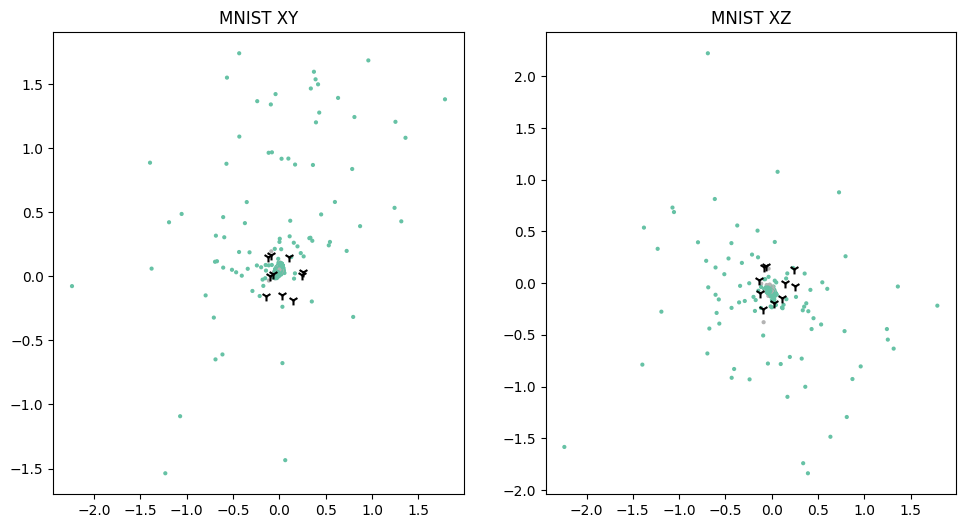

[9328] Reconstruction loss: AUC 0.4335 FZ 0.0070
[9540] Reconstruction loss: AUC 0.3727 FZ 0.0044
[9752] Reconstruction loss: AUC 0.4596 FZ 0.0045


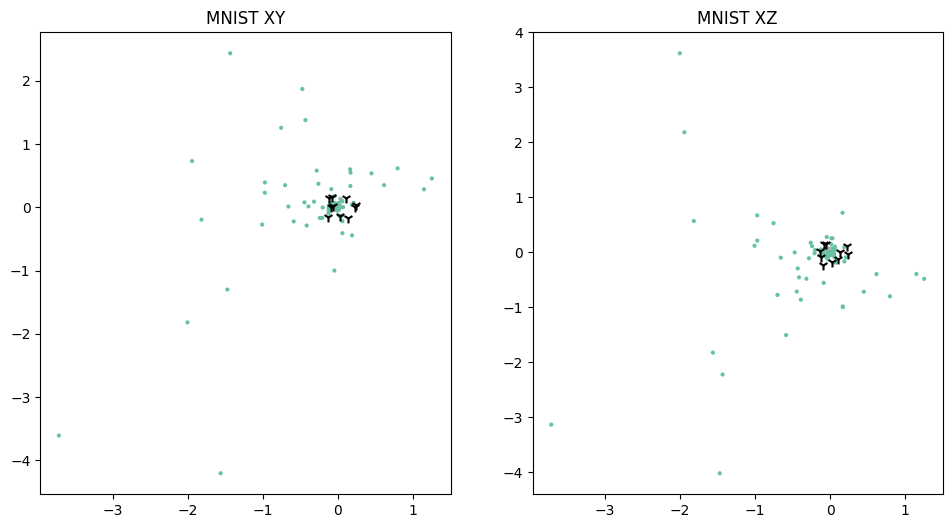

[9964] Reconstruction loss: AUC 0.5302 FZ 0.0034
[10176] Reconstruction loss: AUC 0.5399 FZ 0.0041
[10388] Reconstruction loss: AUC 0.5286 FZ 0.0029


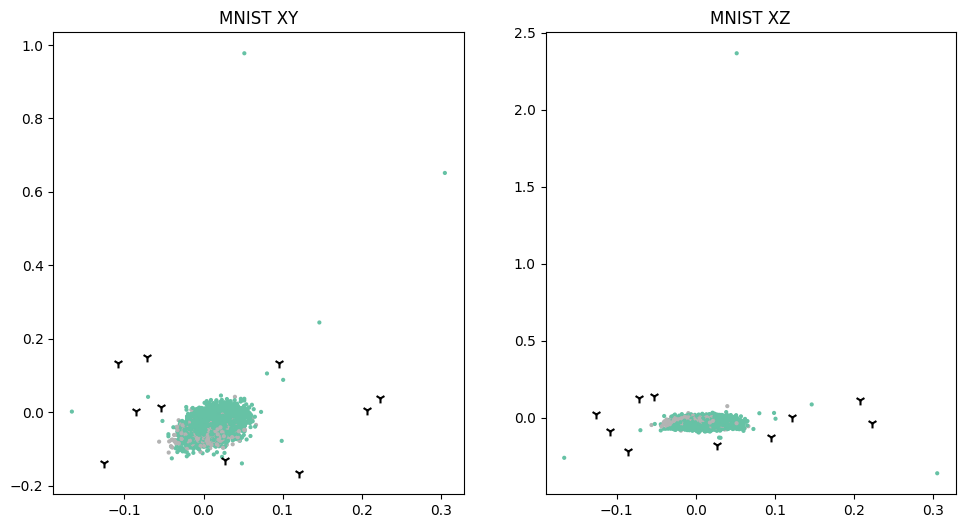

[10600] Reconstruction loss: AUC 0.5653 FZ 0.0003
[10812] Reconstruction loss: AUC 0.5164 FZ 0.0000
[11024] Reconstruction loss: AUC 0.7195 FZ 0.0000


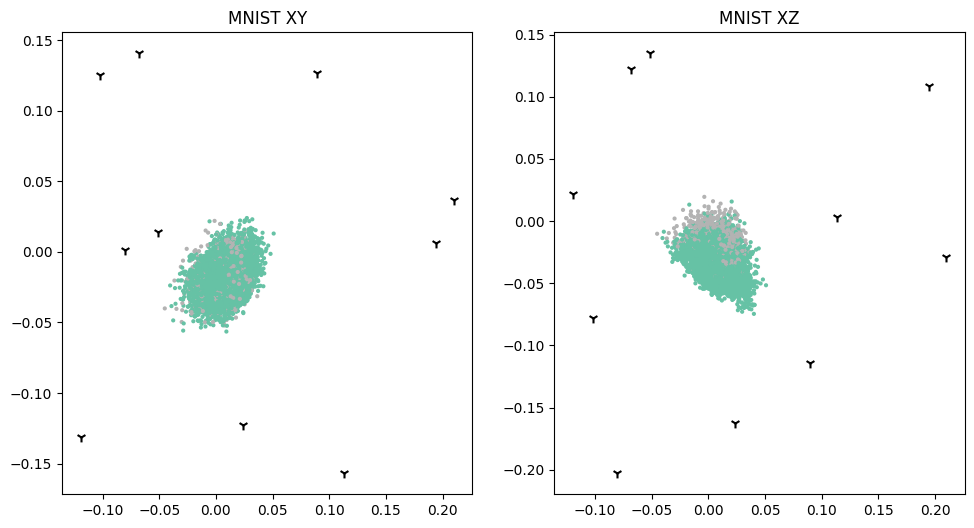

[11236] Reconstruction loss: AUC 0.7159 FZ 0.0000
[11448] Reconstruction loss: AUC 0.6782 FZ 0.0000
[11660] Reconstruction loss: AUC 0.7110 FZ 0.0000


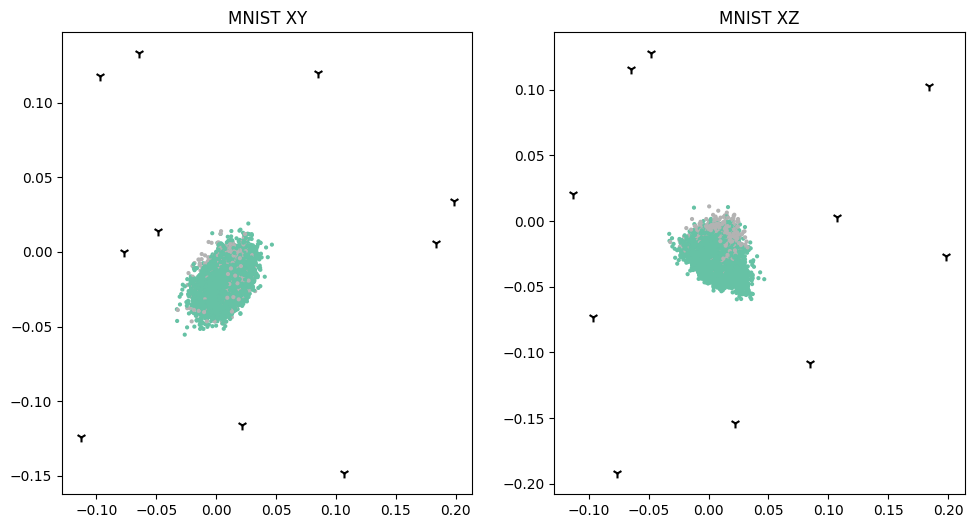

[11872] Reconstruction loss: AUC 0.7218 FZ 0.0000
[12084] Reconstruction loss: AUC 0.7029 FZ 0.0000
[12296] Reconstruction loss: AUC 0.7301 FZ 0.0000


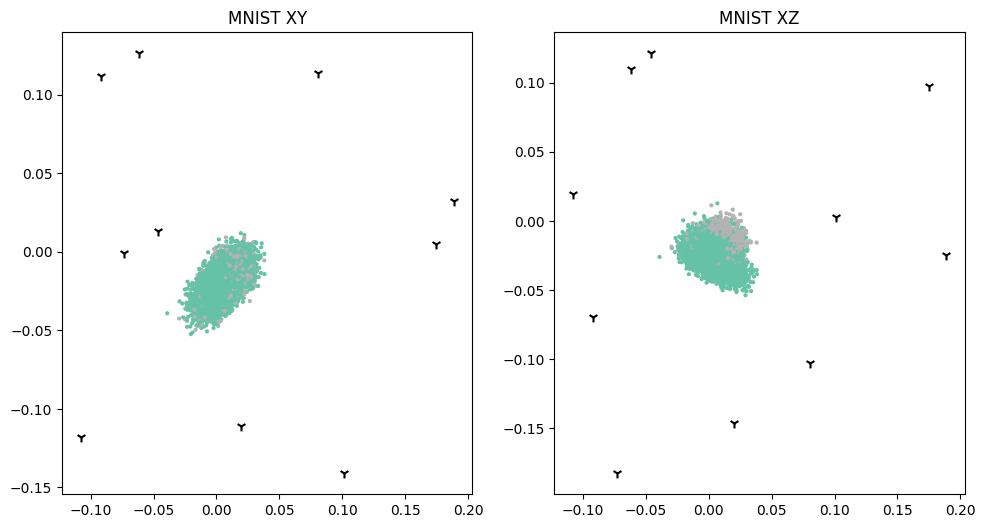

[12508] Reconstruction loss: AUC 0.7342 FZ 0.0000
[12720] Reconstruction loss: AUC 0.6913 FZ 0.0000
[12932] Reconstruction loss: AUC 0.6864 FZ 0.0000


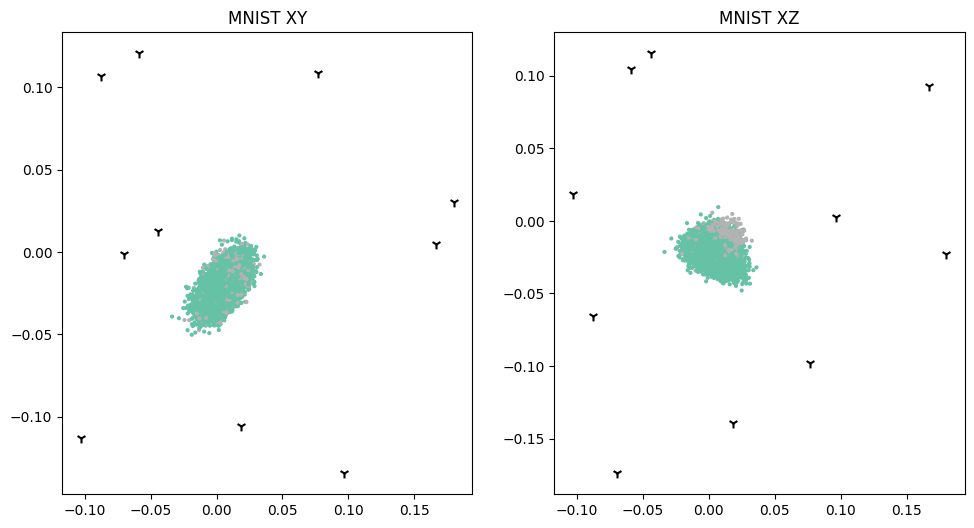

[13144] Reconstruction loss: AUC 0.7164 FZ 0.0000
[13356] Reconstruction loss: AUC 0.6637 FZ 0.0000
[13568] Reconstruction loss: AUC 0.7027 FZ 0.0000


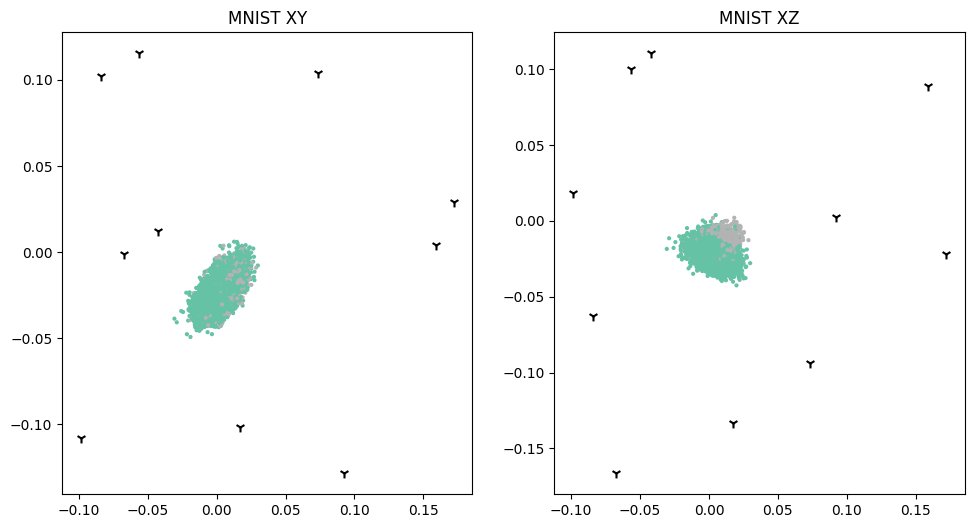

[13780] Reconstruction loss: AUC 0.6937 FZ 0.0000
[13992] Reconstruction loss: AUC 0.6919 FZ 0.0000
[14204] Reconstruction loss: AUC 0.6763 FZ 0.0000


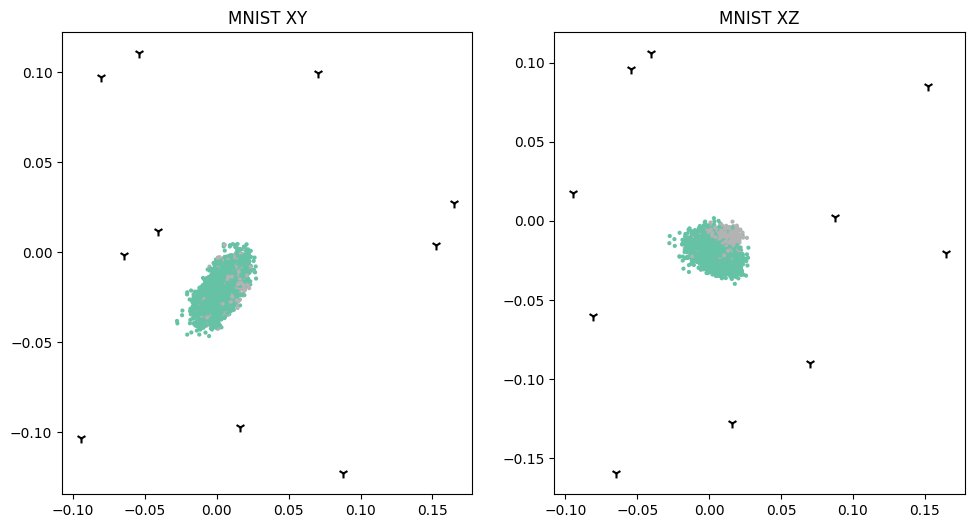

[14416] Reconstruction loss: AUC 0.6471 FZ 0.0000
[14628] Reconstruction loss: AUC 0.6618 FZ 0.0000
[14840] Reconstruction loss: AUC 0.6608 FZ 0.0000


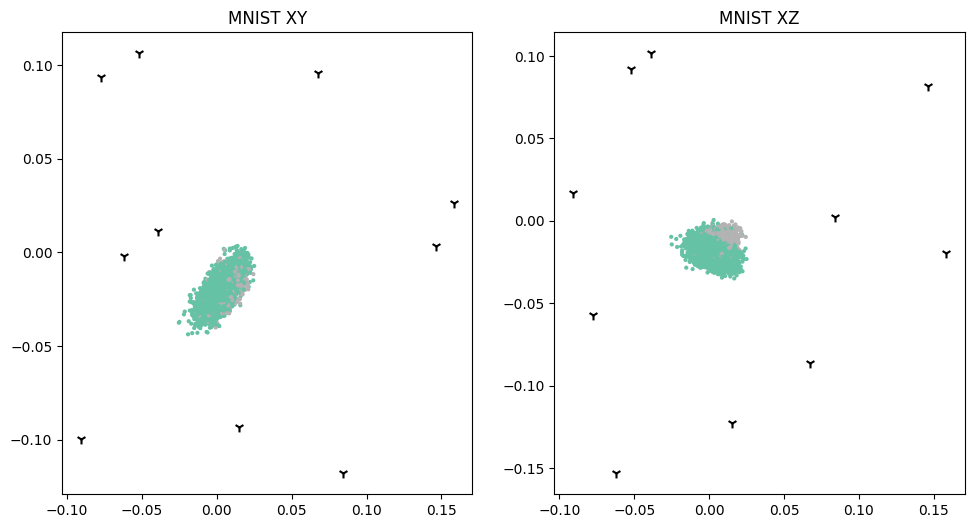

[15052] Reconstruction loss: AUC 0.6890 FZ 0.0000
[15264] Reconstruction loss: AUC 0.6026 FZ 0.0000
[15476] Reconstruction loss: AUC 0.6490 FZ 0.0000


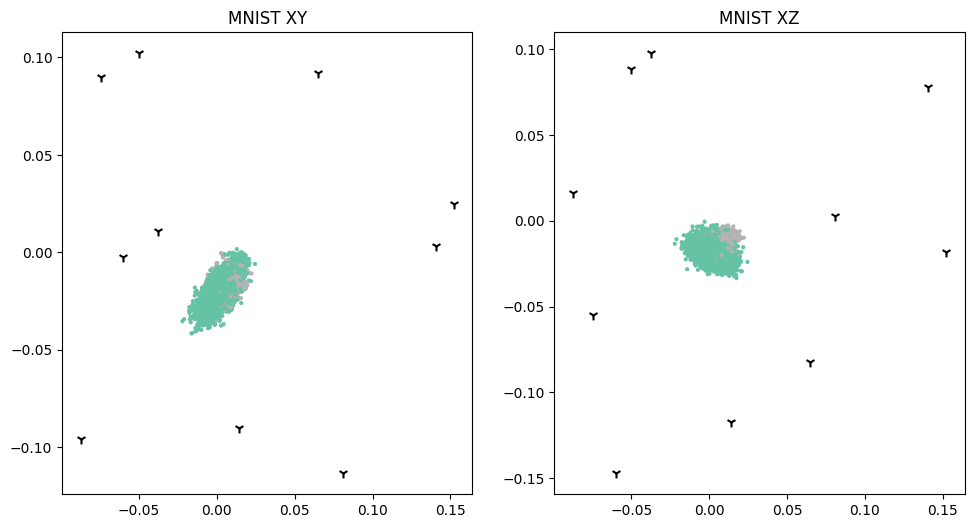

[15688] Reconstruction loss: AUC 0.6263 FZ 0.0000
[15900] Reconstruction loss: AUC 0.6805 FZ 0.0000
[16112] Reconstruction loss: AUC 0.6759 FZ 0.0000


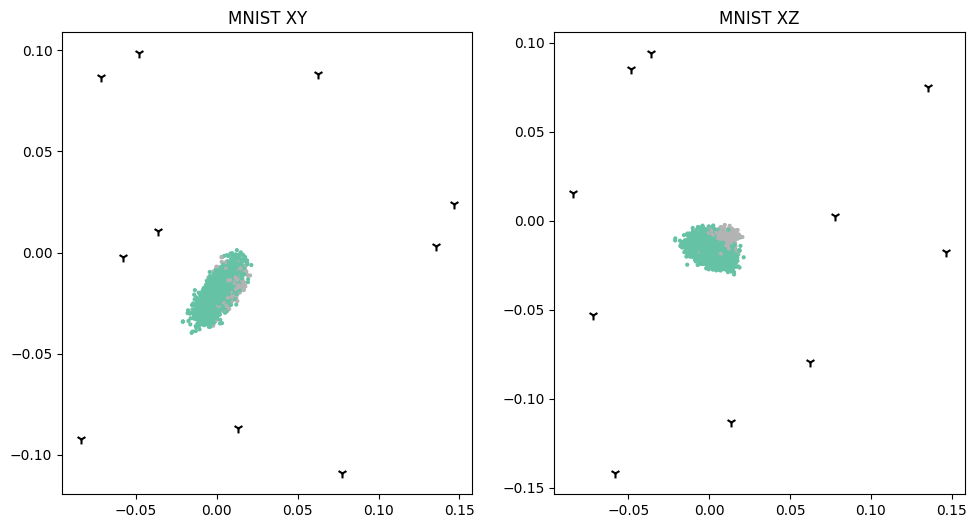

[16324] Reconstruction loss: AUC 0.6565 FZ 0.0000
[16536] Reconstruction loss: AUC 0.6055 FZ 0.0000
[16748] Reconstruction loss: AUC 0.6419 FZ 0.0000


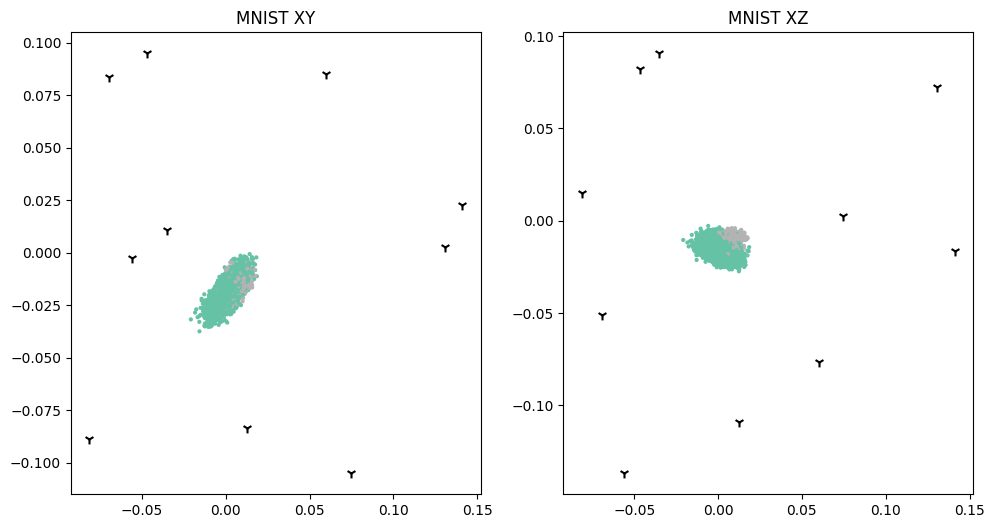

[16960] Reconstruction loss: AUC 0.6717 FZ 0.0000
[17172] Reconstruction loss: AUC 0.6651 FZ 0.0000
[17384] Reconstruction loss: AUC 0.6783 FZ 0.0000


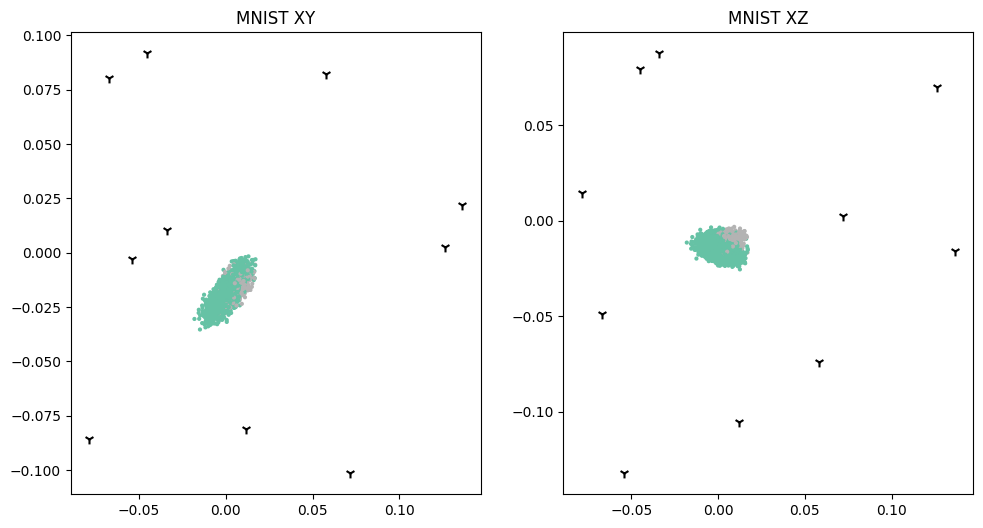

[17596] Reconstruction loss: AUC 0.6944 FZ 0.0000
[17808] Reconstruction loss: AUC 0.6750 FZ 0.0000
[18020] Reconstruction loss: AUC 0.6283 FZ 0.0000


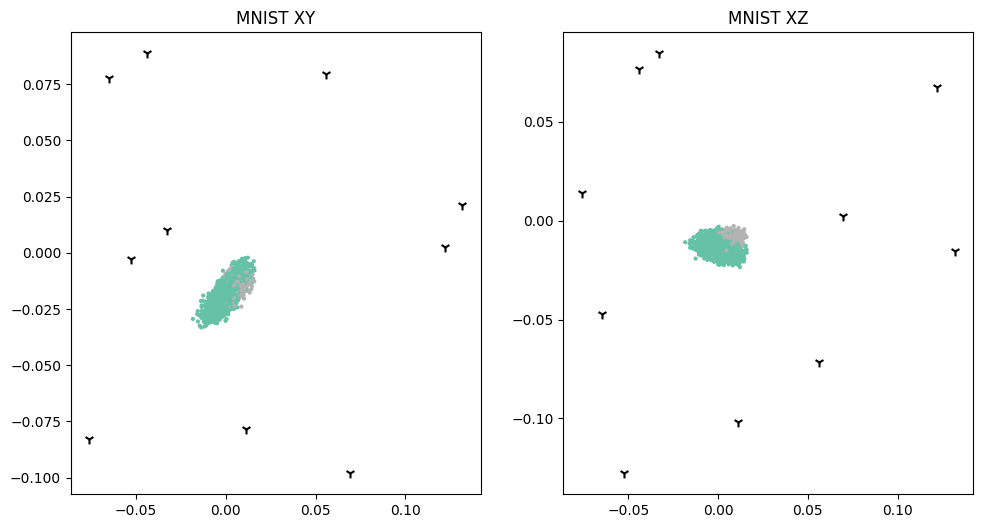

[18232] Reconstruction loss: AUC 0.7168 FZ 0.0000
[18444] Reconstruction loss: AUC 0.6700 FZ 0.0000
[18656] Reconstruction loss: AUC 0.6781 FZ 0.0000


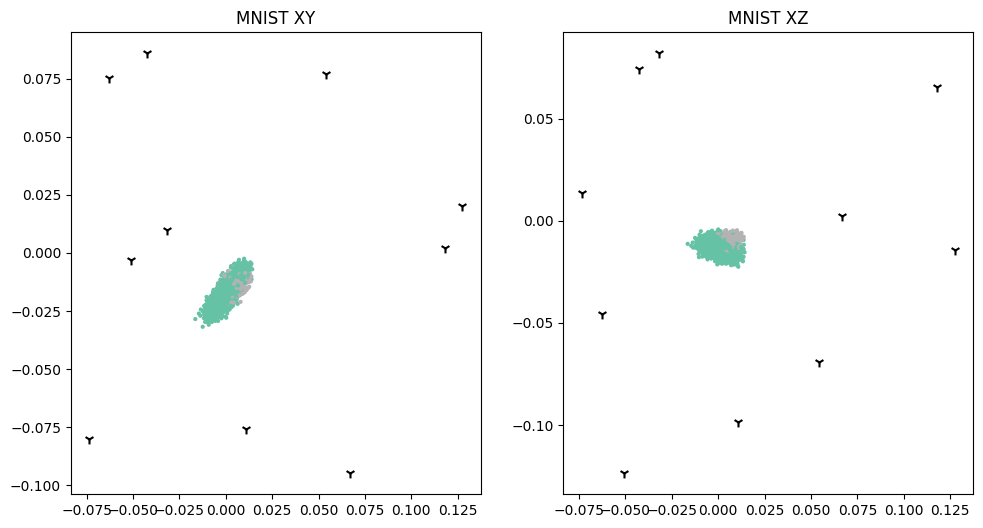

[18868] Reconstruction loss: AUC 0.6613 FZ 0.0000
[19080] Reconstruction loss: AUC 0.6384 FZ 0.0000
[19292] Reconstruction loss: AUC 0.6762 FZ 0.0000


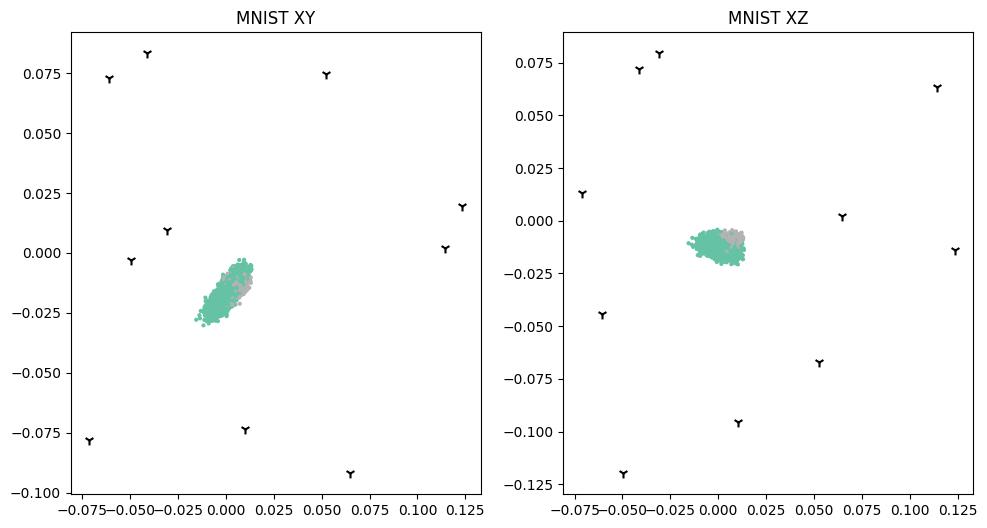

[19504] Reconstruction loss: AUC 0.6707 FZ 0.0000
[19716] Reconstruction loss: AUC 0.6530 FZ 0.0000
[19928] Reconstruction loss: AUC 0.6847 FZ 0.0000


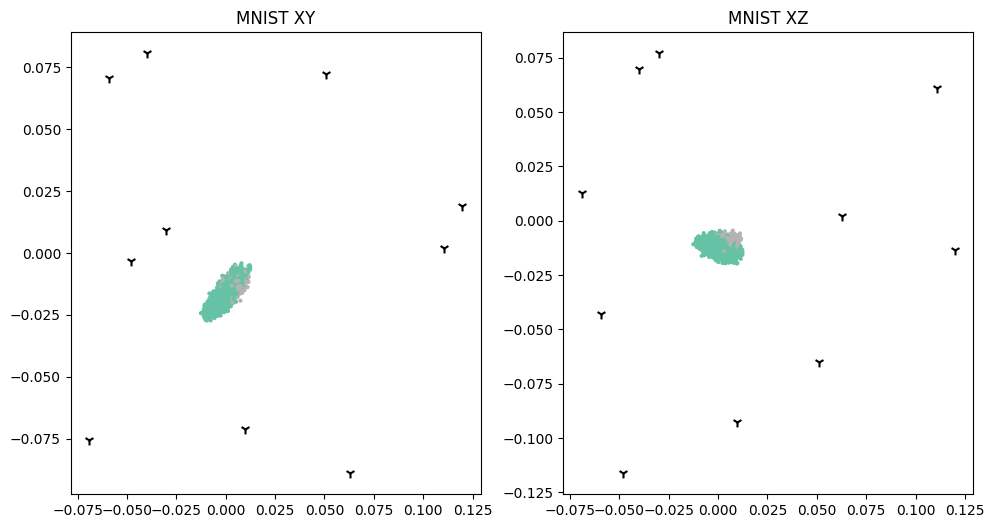

[20140] Reconstruction loss: AUC 0.6720 FZ 0.0000
[20352] Reconstruction loss: AUC 0.7004 FZ 0.0000
[20564] Reconstruction loss: AUC 0.6423 FZ 0.0000


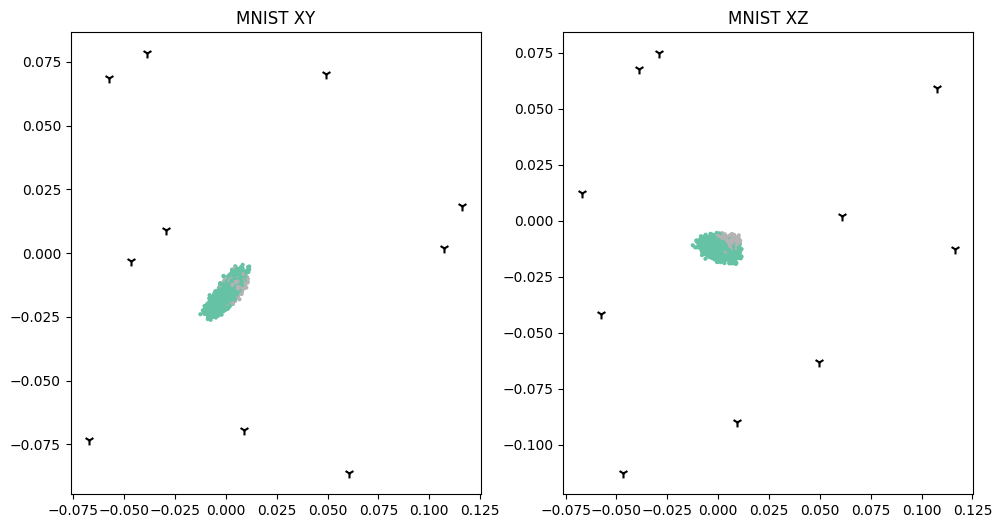

[20776] Reconstruction loss: AUC 0.5880 FZ 0.0000
[20988] Reconstruction loss: AUC 0.6483 FZ 0.0000
[21200] Reconstruction loss: AUC 0.6126 FZ 0.0000


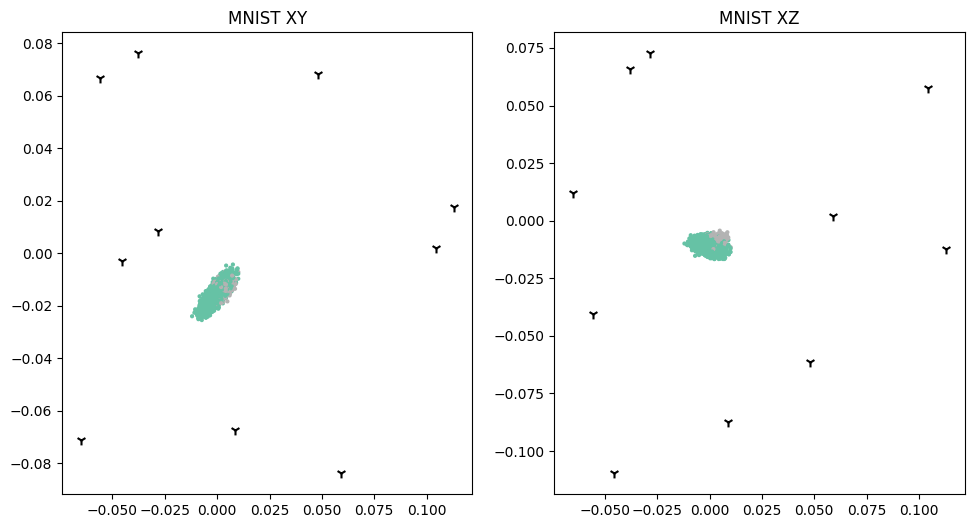

[21412] Reconstruction loss: AUC 0.6681 FZ 0.0000
[21624] Reconstruction loss: AUC 0.3561 FZ 0.9997
[21836] Reconstruction loss: AUC 0.5475 FZ 0.0000


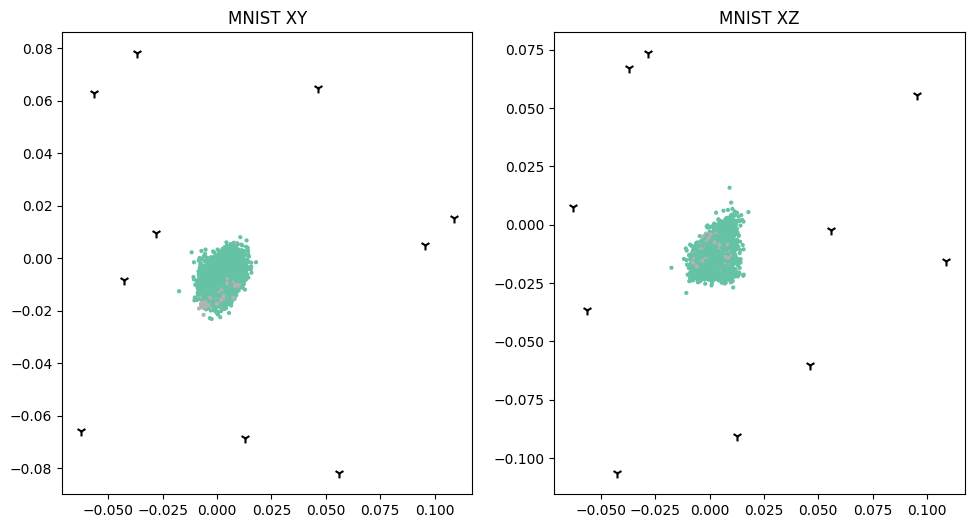

[22048] Reconstruction loss: AUC 0.6087 FZ 0.0000
[22260] Reconstruction loss: AUC 0.6282 FZ 0.0000
[22472] Reconstruction loss: AUC 0.6195 FZ 0.0000


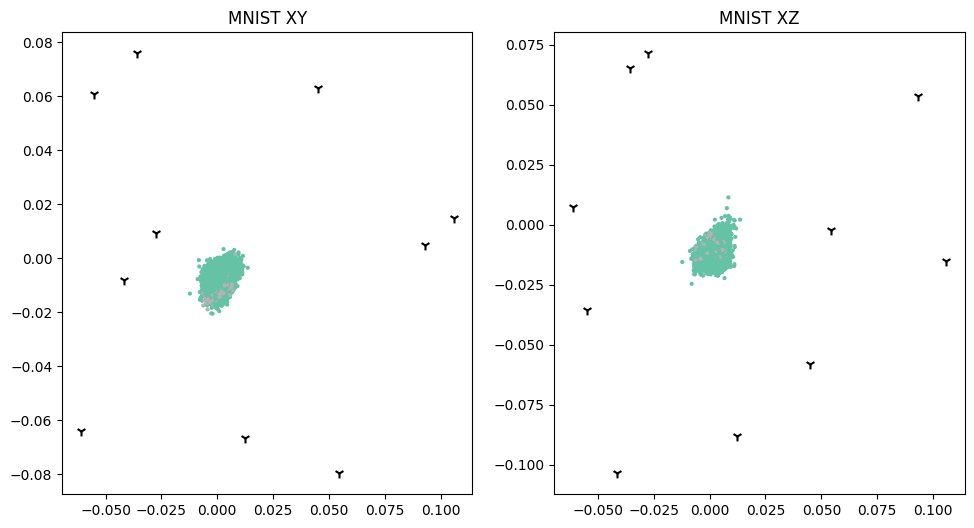

[22684] Reconstruction loss: AUC 0.6281 FZ 0.0000
[22896] Reconstruction loss: AUC 0.6361 FZ 0.0000
[23108] Reconstruction loss: AUC 0.6346 FZ 0.0000


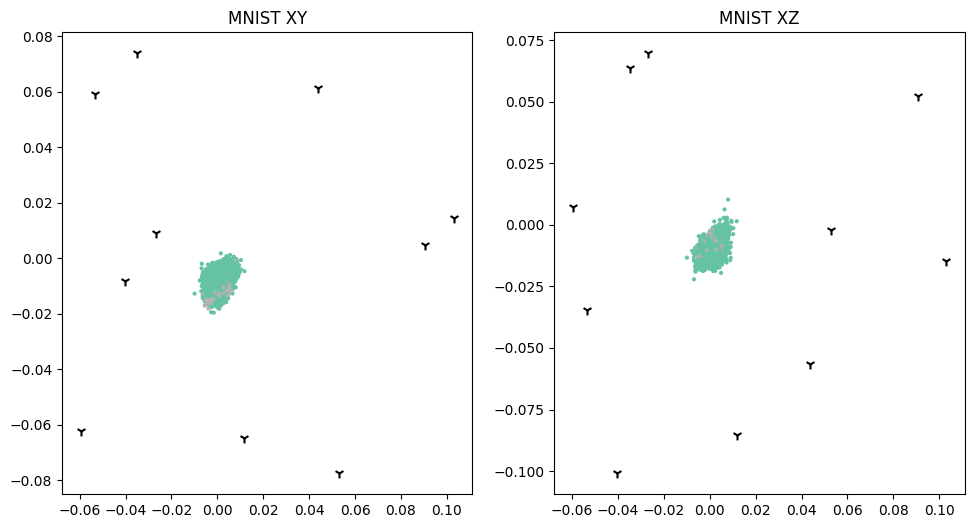

[23320] Reconstruction loss: AUC 0.6412 FZ 0.0000
[23532] Reconstruction loss: AUC 0.6370 FZ 0.0000
[23744] Reconstruction loss: AUC 0.6402 FZ 0.0000


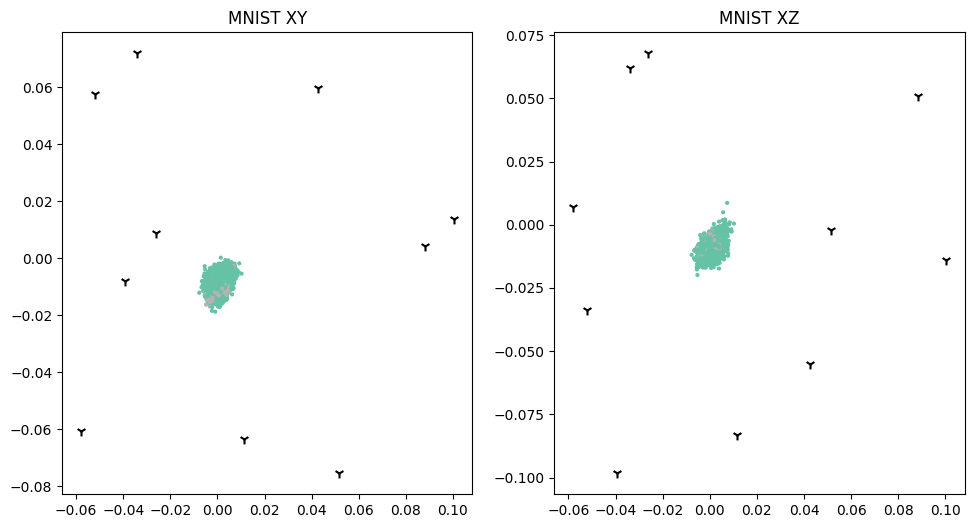

[23956] Reconstruction loss: AUC 0.6462 FZ 0.0000
[24168] Reconstruction loss: AUC 0.6326 FZ 0.0000
[24380] Reconstruction loss: AUC 0.6442 FZ 0.0000


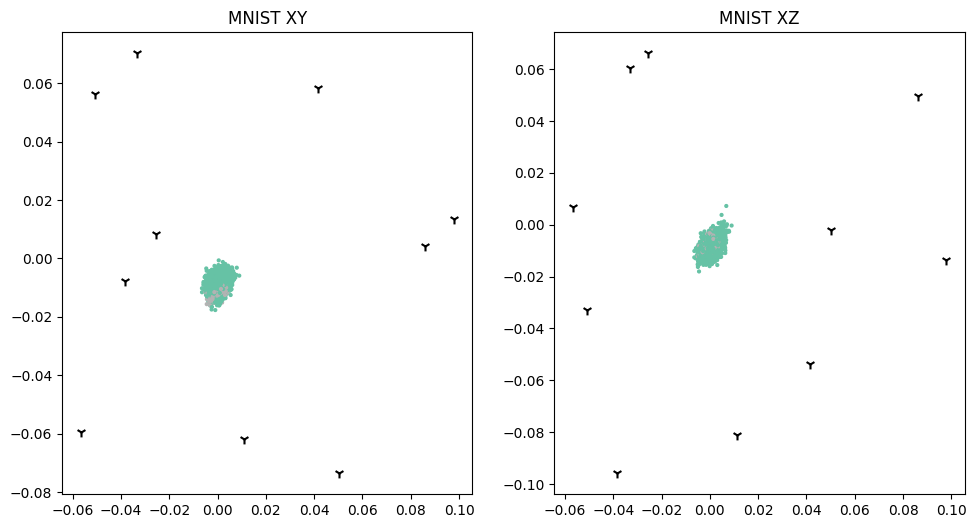

[24592] Reconstruction loss: AUC 0.6317 FZ 0.0000
[24804] Reconstruction loss: AUC 0.6398 FZ 0.0000
[25016] Reconstruction loss: AUC 0.6388 FZ 0.0000


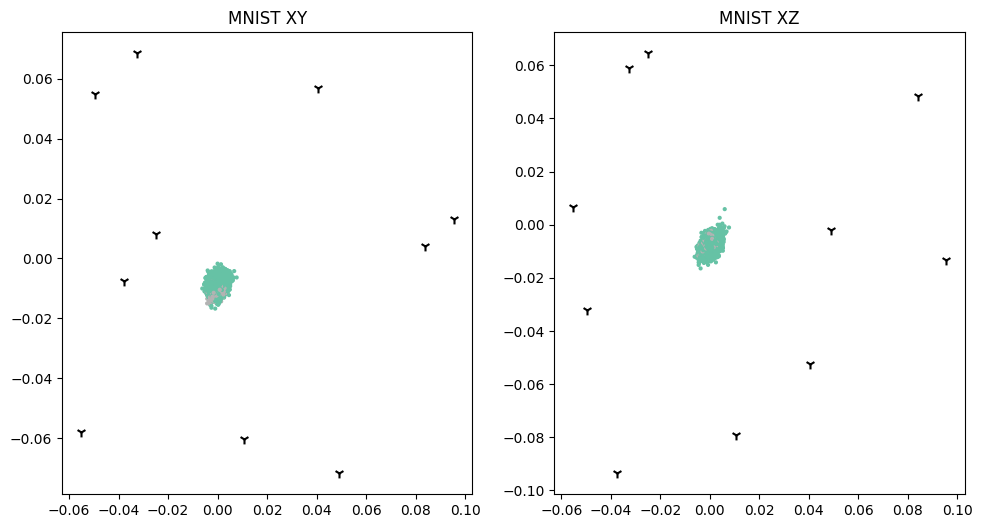

[25228] Reconstruction loss: AUC 0.6460 FZ 0.0000
[25440] Reconstruction loss: AUC 0.6324 FZ 0.0000
[25652] Reconstruction loss: AUC 0.6404 FZ 0.0000


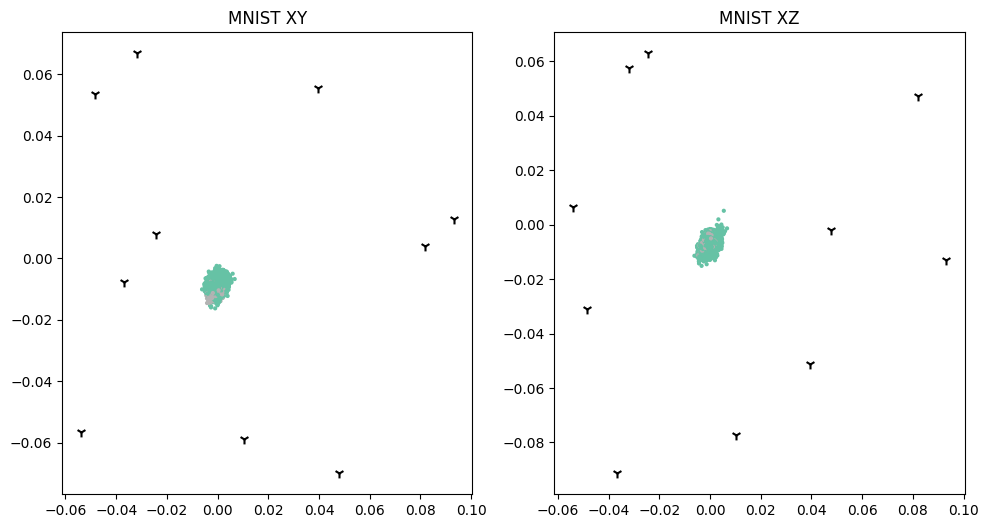

[25864] Reconstruction loss: AUC 0.6398 FZ 0.0000
[26076] Reconstruction loss: AUC 0.6434 FZ 0.0000
[26288] Reconstruction loss: AUC 0.6407 FZ 0.0000


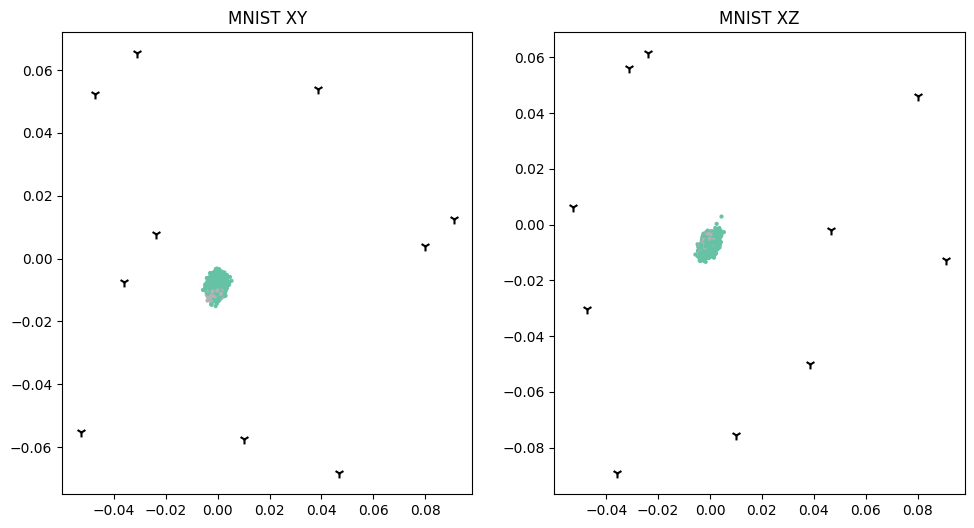

[26500] Reconstruction loss: AUC 0.6286 FZ 0.0000
[26712] Reconstruction loss: AUC 0.6315 FZ 0.0000
[26924] Reconstruction loss: AUC 0.6508 FZ 0.0000


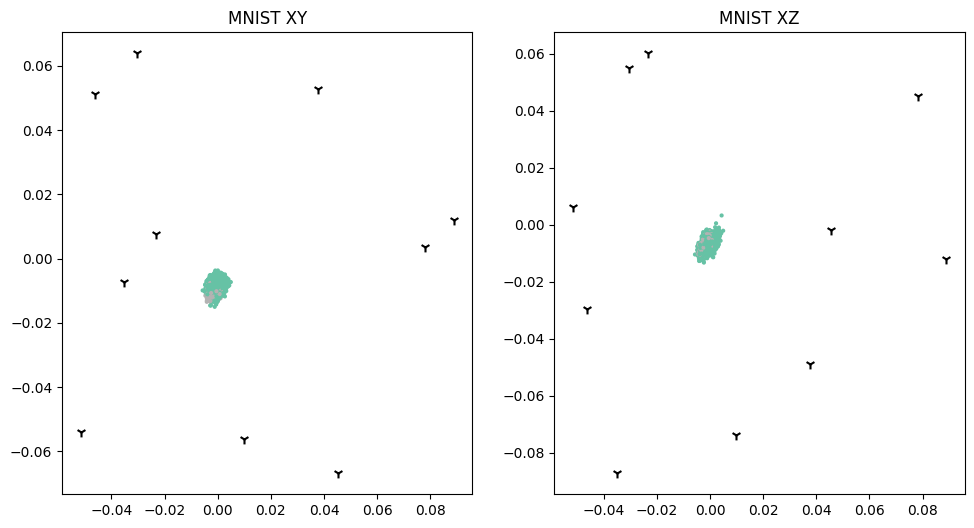

[27136] Reconstruction loss: AUC 0.6439 FZ 0.0000
[27348] Reconstruction loss: AUC 0.6534 FZ 0.0000
[27560] Reconstruction loss: AUC 0.6438 FZ 0.0000


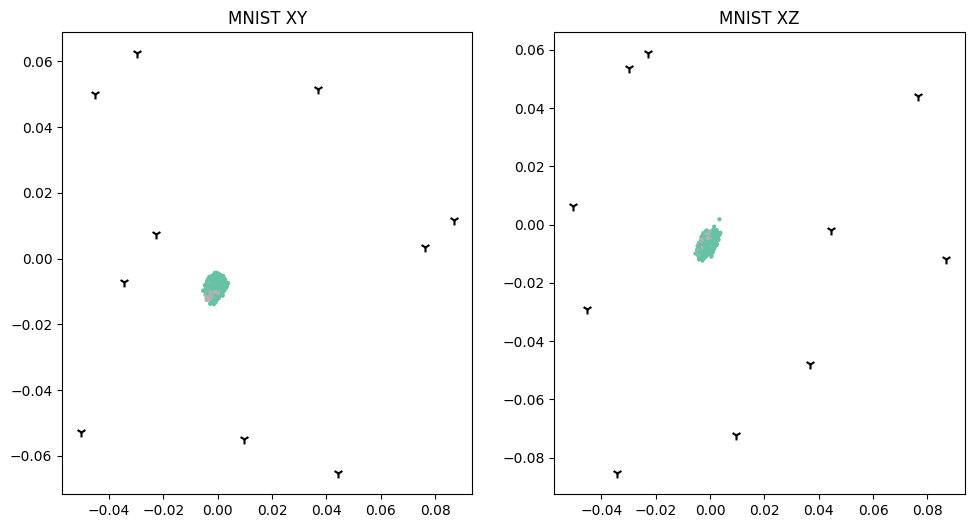

[27772] Reconstruction loss: AUC 0.6494 FZ 0.0000
[27984] Reconstruction loss: AUC 0.6496 FZ 0.0000
[28196] Reconstruction loss: AUC 0.6329 FZ 0.0000


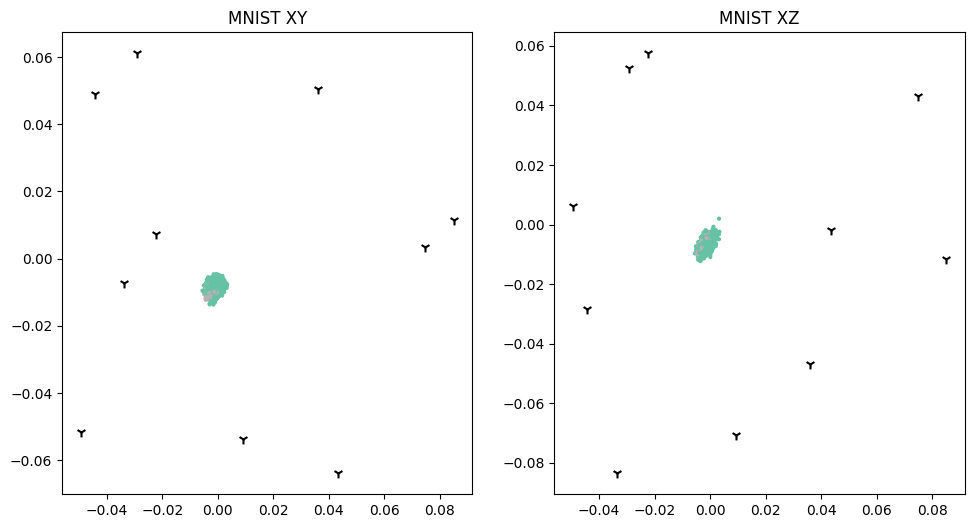

[28408] Reconstruction loss: AUC 0.6441 FZ 0.0000
[28620] Reconstruction loss: AUC 0.6552 FZ 0.0000
[28832] Reconstruction loss: AUC 0.6541 FZ 0.0000


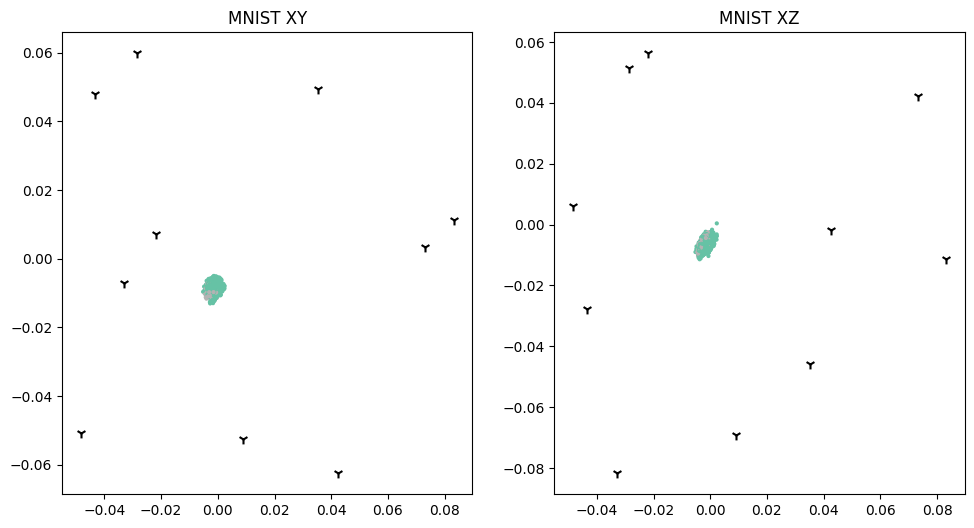

[29044] Reconstruction loss: AUC 0.6368 FZ 0.0000
[29256] Reconstruction loss: AUC 0.6475 FZ 0.0000
[29468] Reconstruction loss: AUC 0.6430 FZ 0.0000


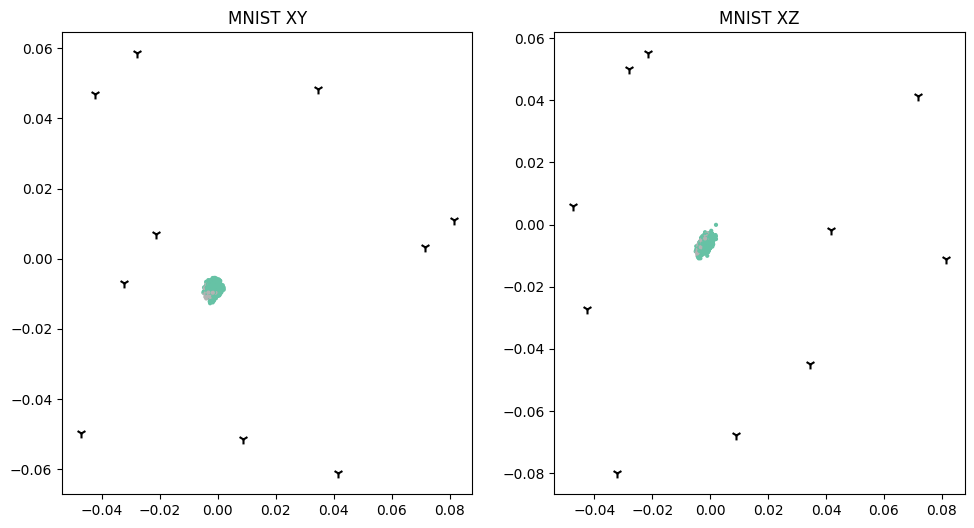

[29680] Reconstruction loss: AUC 0.6523 FZ 0.0000
[29892] Reconstruction loss: AUC 0.6321 FZ 0.0000
[30104] Reconstruction loss: AUC 0.6193 FZ 0.0000


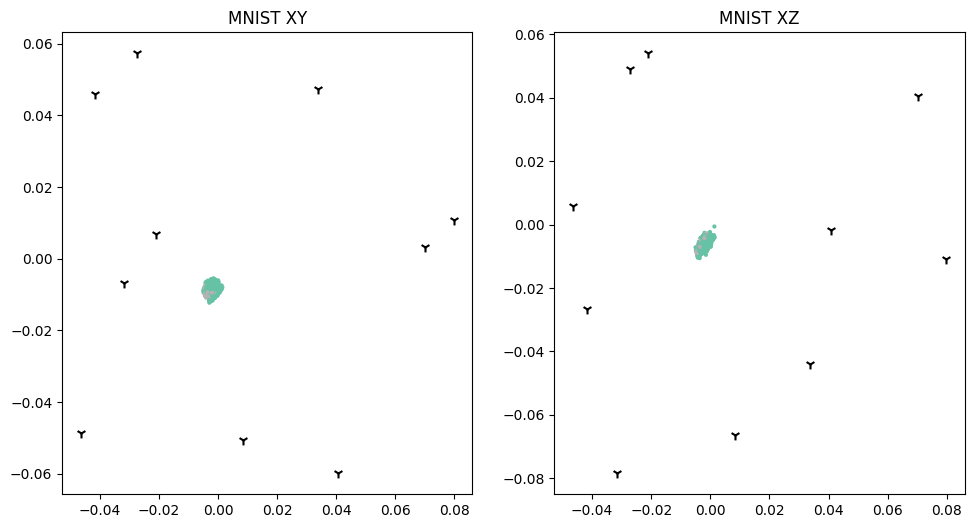

[30316] Reconstruction loss: AUC 0.6531 FZ 0.0000
[30528] Reconstruction loss: AUC 0.6390 FZ 0.0000
[30740] Reconstruction loss: AUC 0.5888 FZ 0.0000


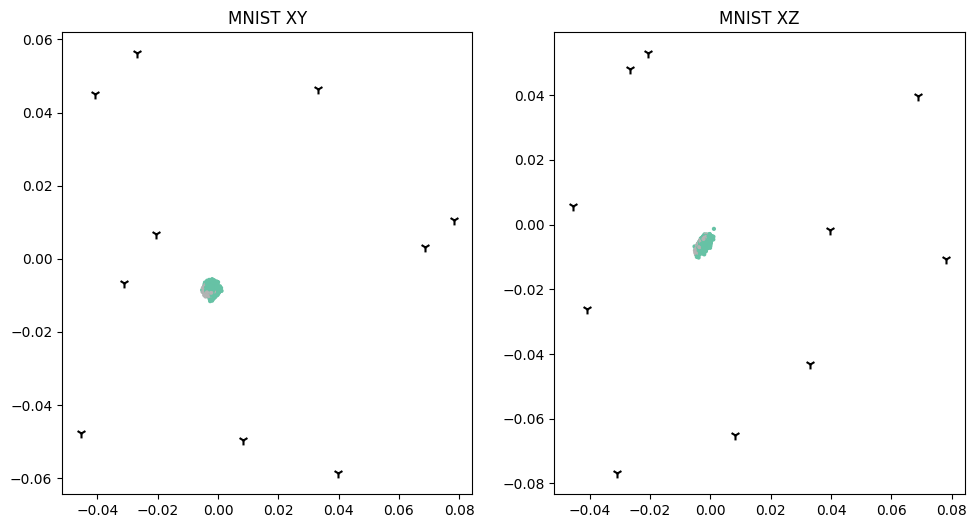

[30952] Reconstruction loss: AUC 0.6197 FZ 0.0000
[31164] Reconstruction loss: AUC 0.6635 FZ 0.0000
[31376] Reconstruction loss: AUC 0.4826 FZ 0.0000


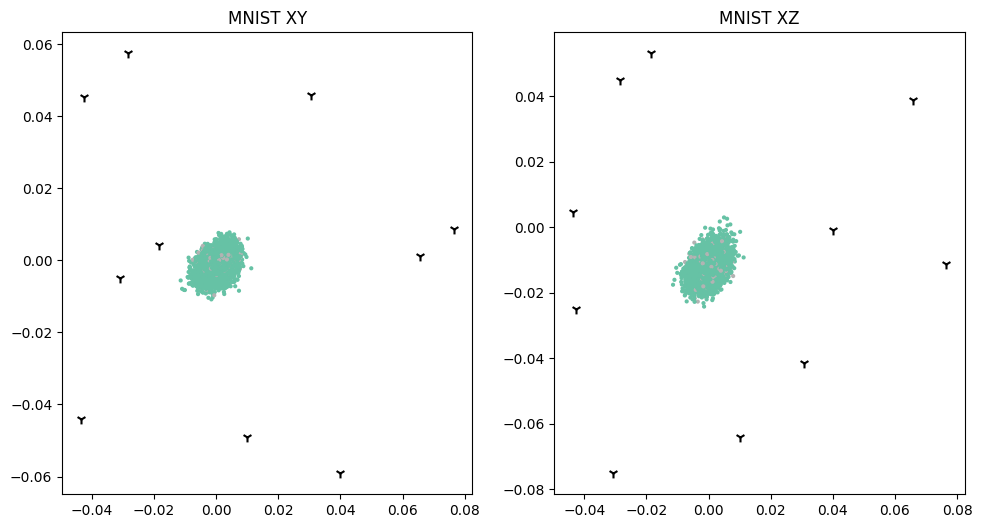

[31588] Reconstruction loss: AUC 0.4793 FZ 0.0000
[31800] Reconstruction loss: AUC 0.4853 FZ 0.0000
[32012] Reconstruction loss: AUC 0.4848 FZ 0.0000


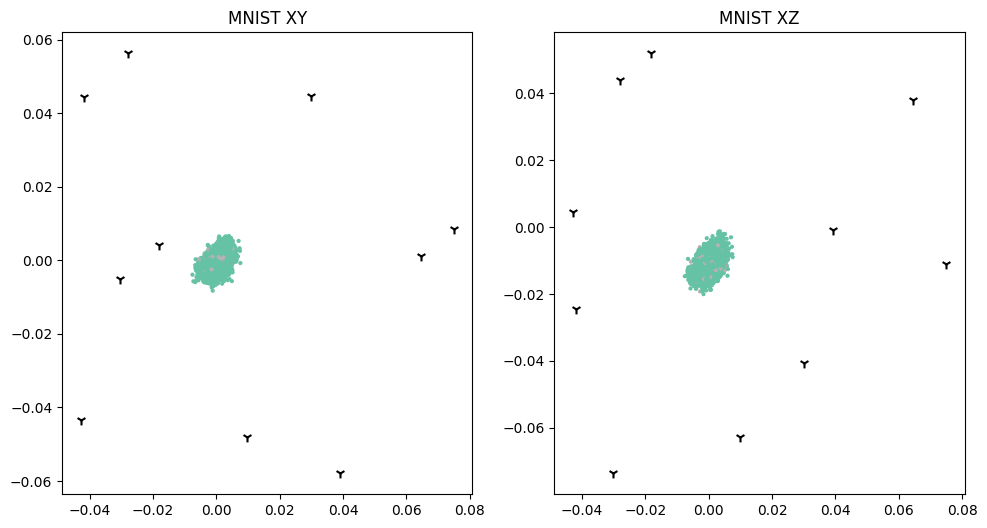

[32224] Reconstruction loss: AUC 0.4882 FZ 0.0000
[32436] Reconstruction loss: AUC 0.4864 FZ 0.0000
[32648] Reconstruction loss: AUC 0.4834 FZ 0.0000


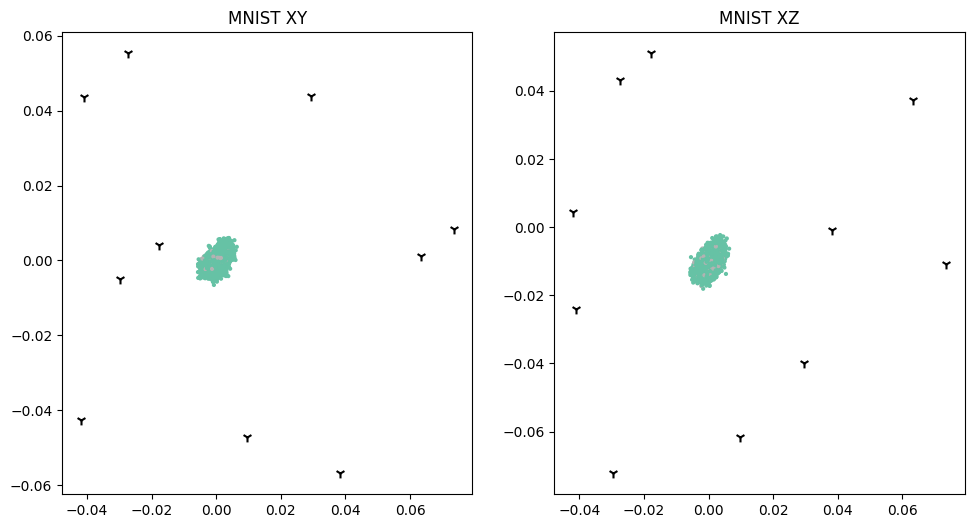

[32860] Reconstruction loss: AUC 0.4860 FZ 0.0000
[33072] Reconstruction loss: AUC 0.4891 FZ 0.0000
[33284] Reconstruction loss: AUC 0.4829 FZ 0.0000


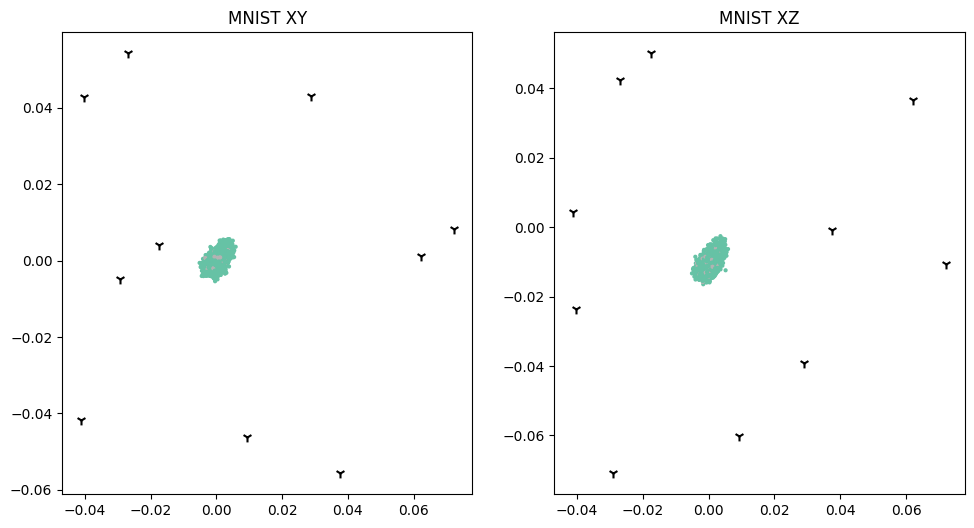

[33496] Reconstruction loss: AUC 0.4870 FZ 0.0000
[33708] Reconstruction loss: AUC 0.4863 FZ 0.0000
[33920] Reconstruction loss: AUC 0.4881 FZ 0.0000


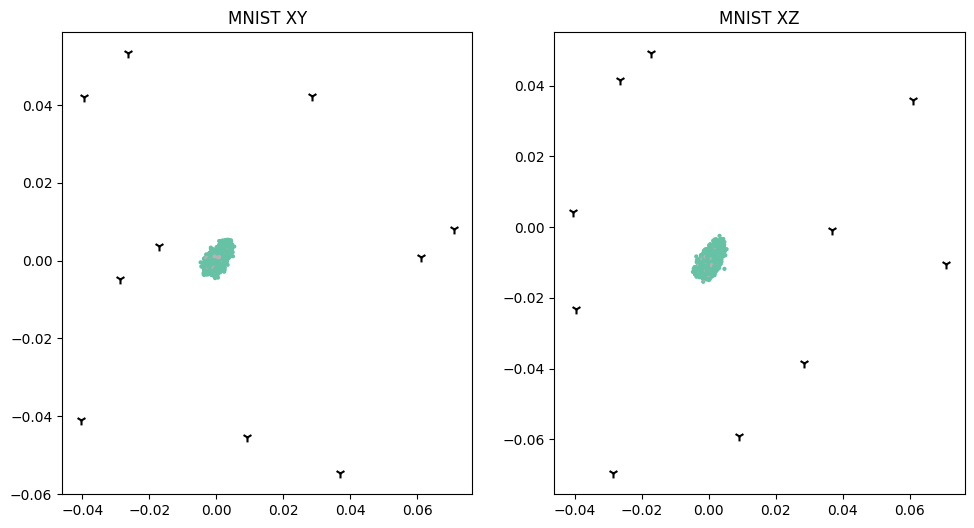

[34132] Reconstruction loss: AUC 0.4875 FZ 0.0000
[34344] Reconstruction loss: AUC 0.4893 FZ 0.0000
[34556] Reconstruction loss: AUC 0.4860 FZ 0.0000


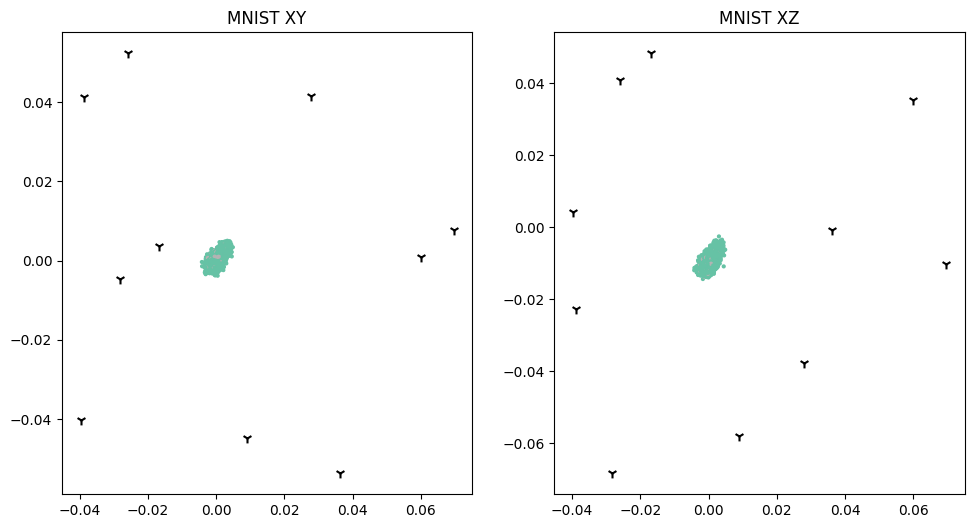

[34768] Reconstruction loss: AUC 0.4961 FZ 0.0000
[34980] Reconstruction loss: AUC 0.4936 FZ 0.0000
[35192] Reconstruction loss: AUC 0.4937 FZ 0.0000


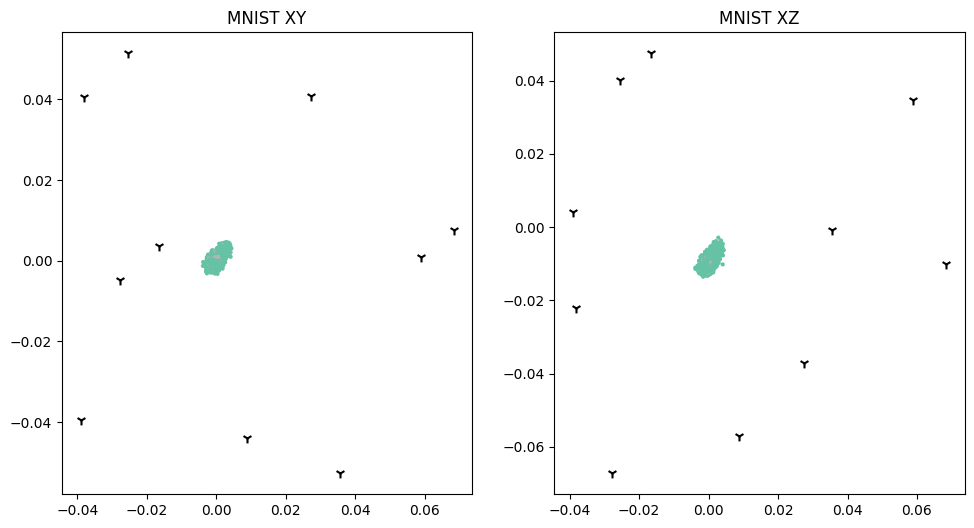

[35404] Reconstruction loss: AUC 0.4960 FZ 0.0000
[35616] Reconstruction loss: AUC 0.4947 FZ 0.0000
[35828] Reconstruction loss: AUC 0.4990 FZ 0.0000


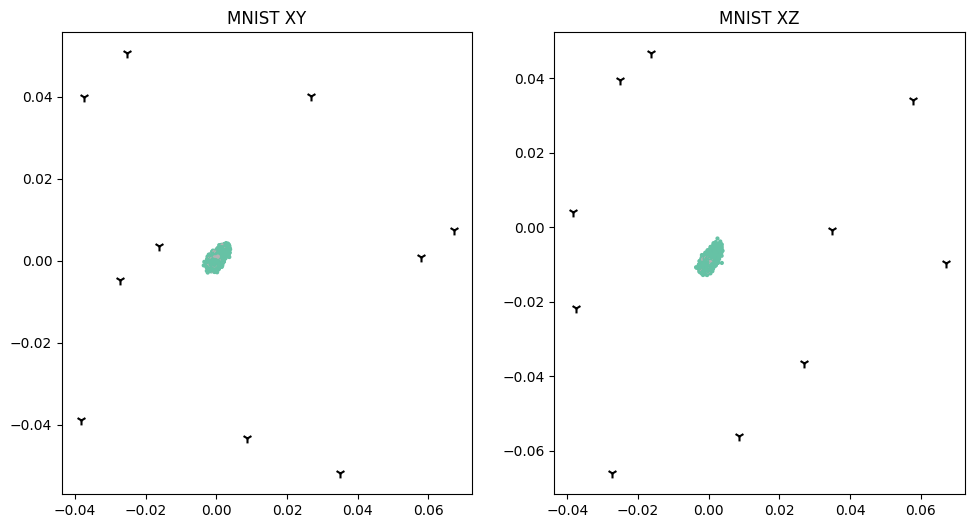

[36040] Reconstruction loss: AUC 0.4999 FZ 0.0000
[36252] Reconstruction loss: AUC 0.5040 FZ 0.0000
[36464] Reconstruction loss: AUC 0.5039 FZ 0.0000


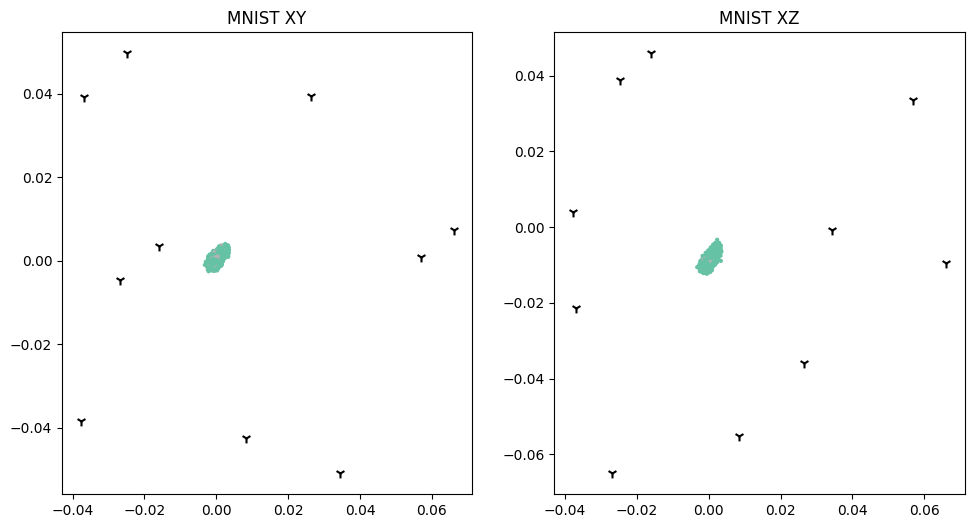

[36676] Reconstruction loss: AUC 0.5034 FZ 0.0000
[36888] Reconstruction loss: AUC 0.5048 FZ 0.0000
[37100] Reconstruction loss: AUC 0.5050 FZ 0.0000


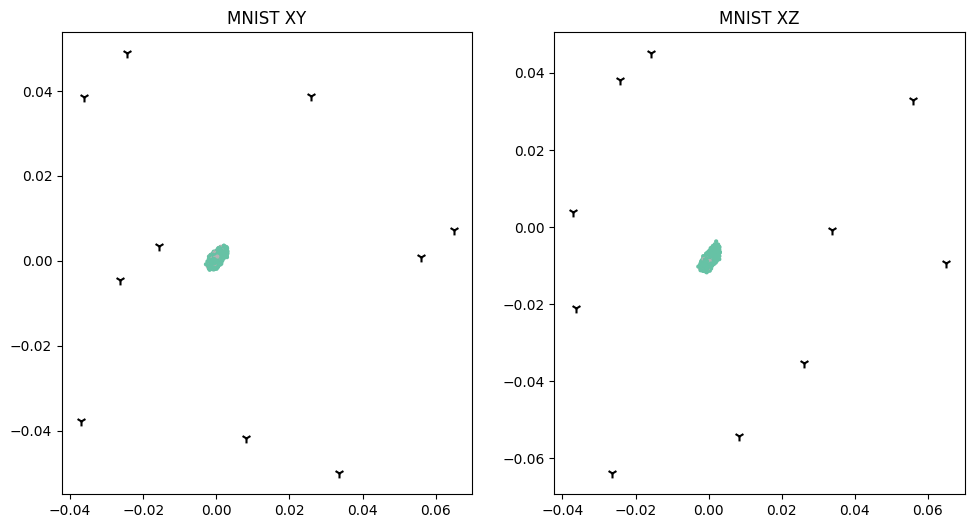

[37312] Reconstruction loss: AUC 0.5008 FZ 0.0000
[37524] Reconstruction loss: AUC 0.5058 FZ 0.0000
[37736] Reconstruction loss: AUC 0.5022 FZ 0.0000


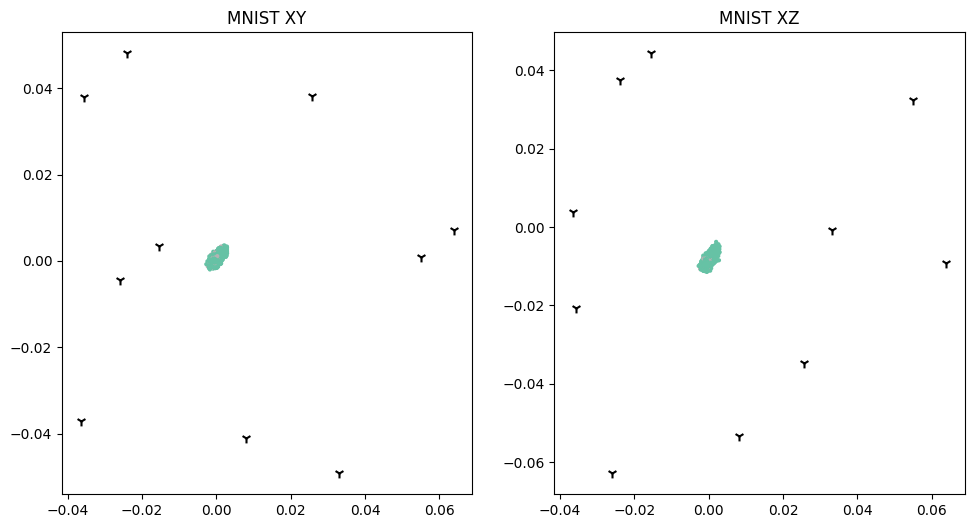

[37948] Reconstruction loss: AUC 0.5065 FZ 0.0000
[38160] Reconstruction loss: AUC 0.5012 FZ 0.0000
[38372] Reconstruction loss: AUC 0.4991 FZ 0.0000


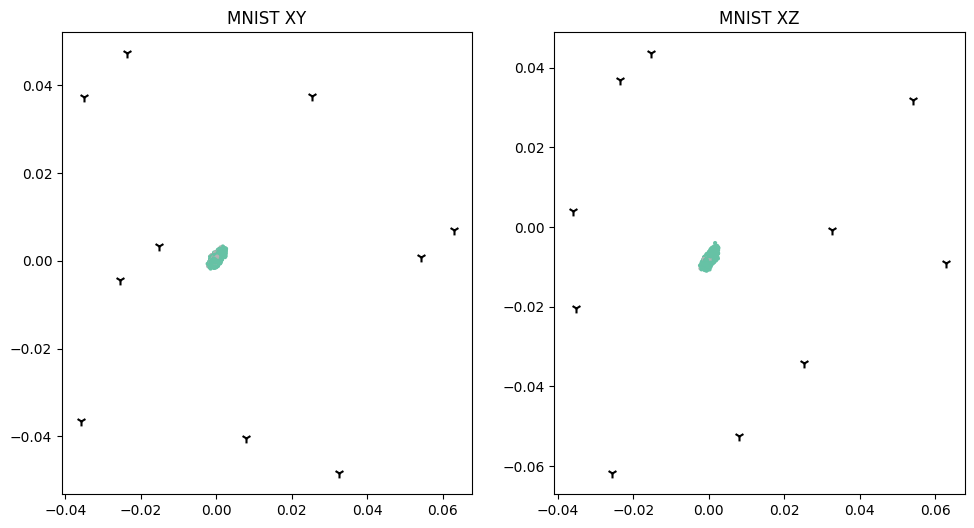

[38584] Reconstruction loss: AUC 0.4986 FZ 0.0000
[38796] Reconstruction loss: AUC 0.5095 FZ 0.0000
[39008] Reconstruction loss: AUC 0.5087 FZ 0.0000


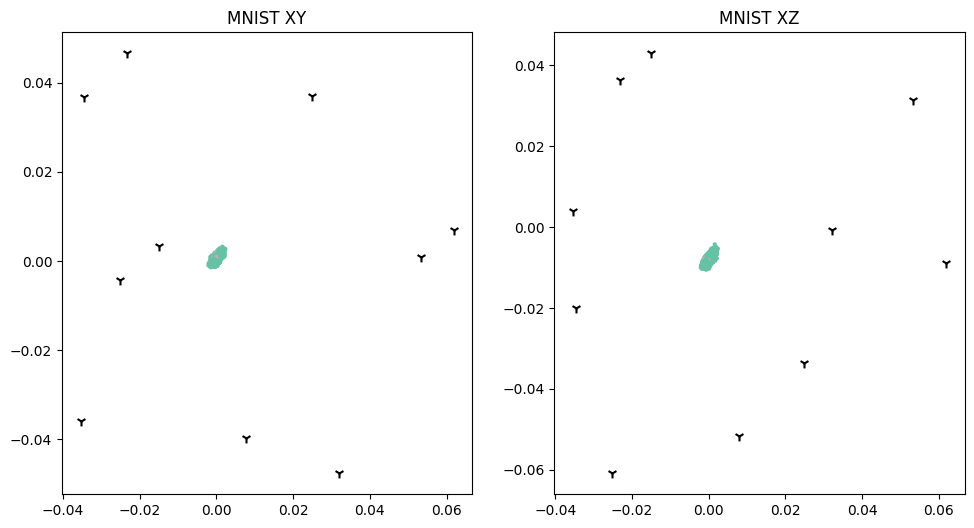

[39220] Reconstruction loss: AUC 0.4930 FZ 0.0000
[39432] Reconstruction loss: AUC 0.5131 FZ 0.0000
[39644] Reconstruction loss: AUC 0.4706 FZ 0.0000


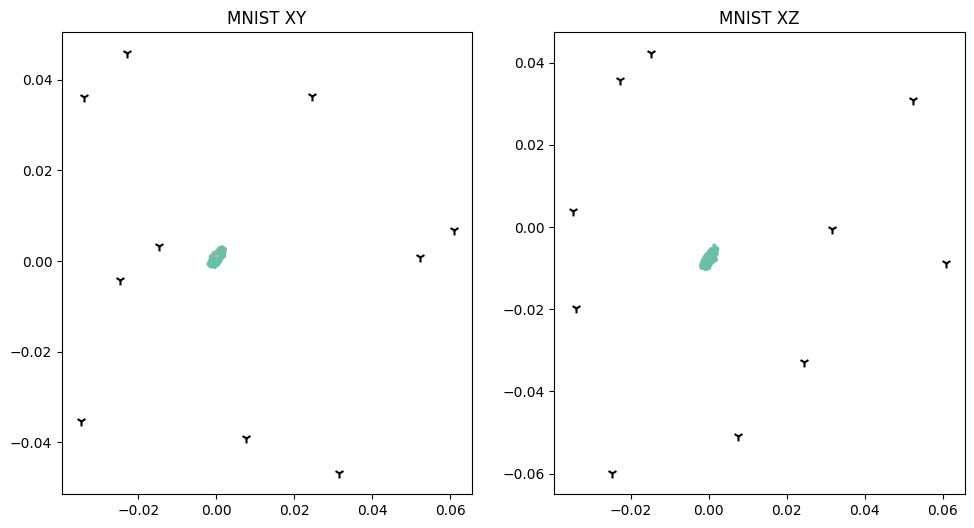

[39856] Reconstruction loss: AUC 0.4961 FZ 0.0000
[40068] Reconstruction loss: AUC 0.4808 FZ 0.0000
[40280] Reconstruction loss: AUC 0.4824 FZ 0.0000


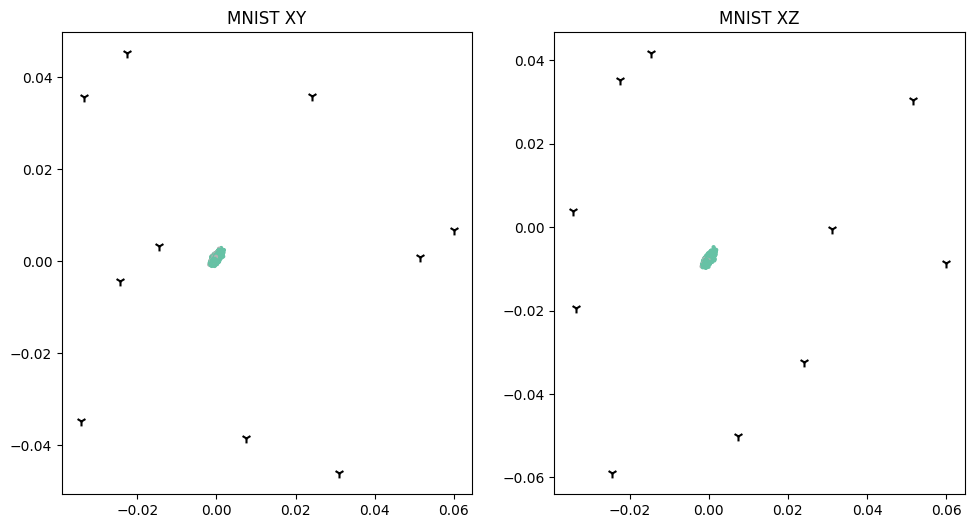

[40492] Reconstruction loss: AUC 0.4970 FZ 0.0000
[40704] Reconstruction loss: AUC 0.4893 FZ 0.0000
[40916] Reconstruction loss: AUC 0.5160 FZ 0.0000


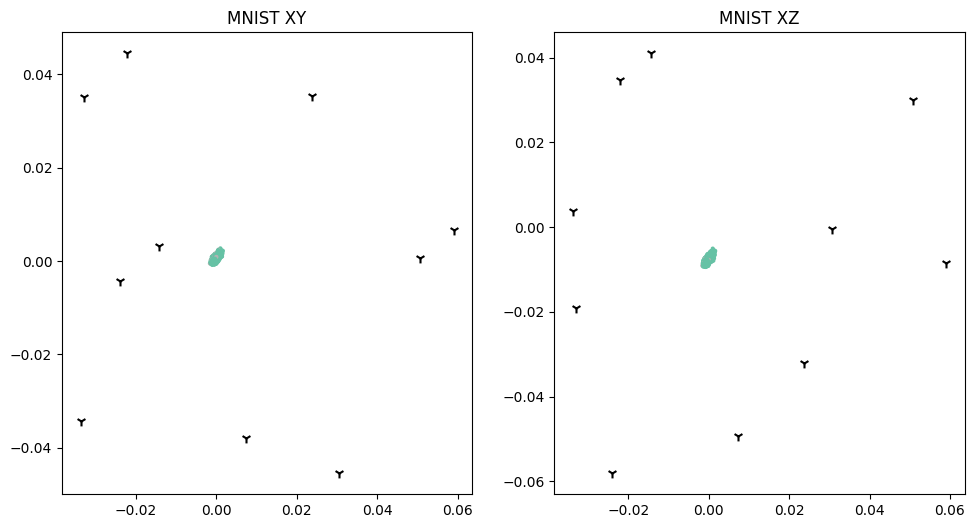

[41128] Reconstruction loss: AUC 0.4873 FZ 0.0000
[41340] Reconstruction loss: AUC 0.5090 FZ 0.0000
[41552] Reconstruction loss: AUC 0.4724 FZ 0.0000


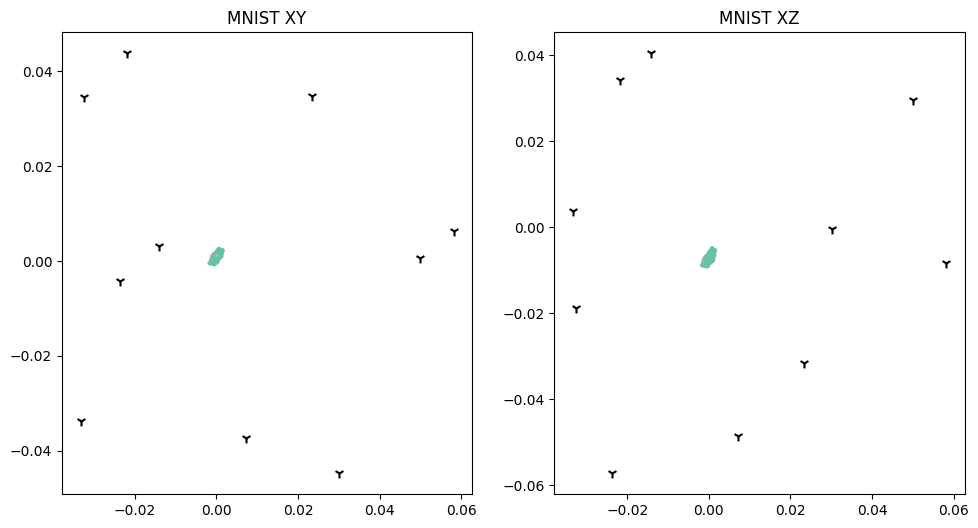

[41764] Reconstruction loss: AUC 0.5436 FZ 0.0000
[41976] Reconstruction loss: AUC 0.5128 FZ 0.0000
[42188] Reconstruction loss: AUC 0.4846 FZ 0.0000


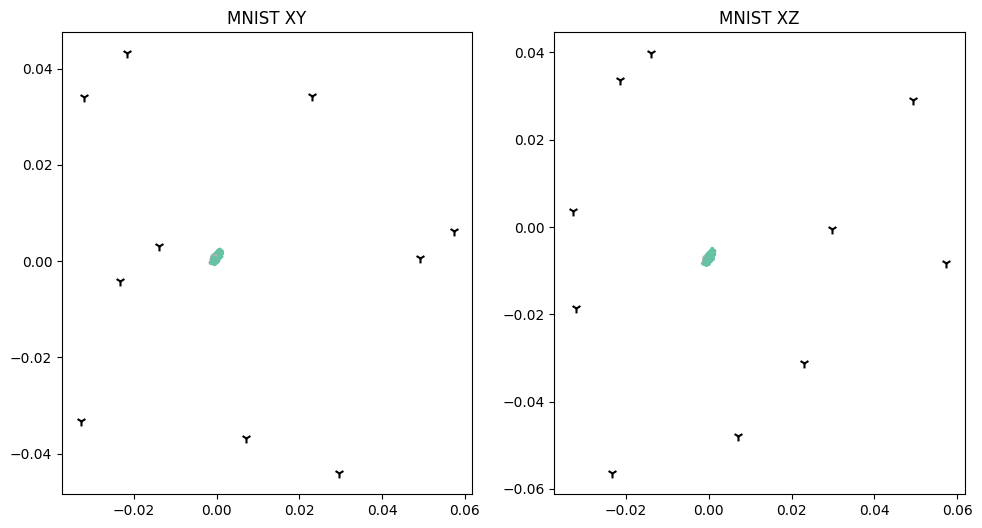

[42400] Reconstruction loss: AUC 0.4999 FZ 0.0000
[42612] Reconstruction loss: AUC 0.4895 FZ 0.0000
[42824] Reconstruction loss: AUC 0.5024 FZ 0.0000


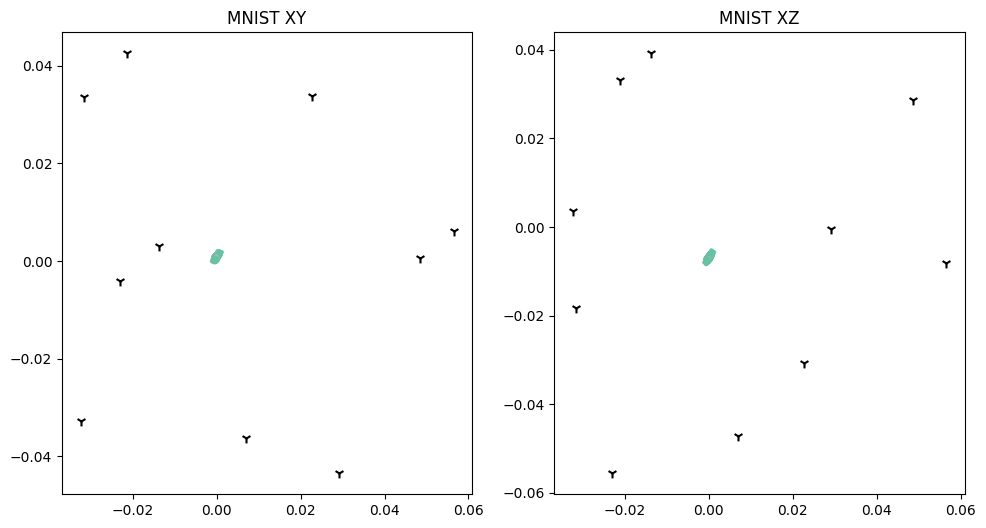

[43036] Reconstruction loss: AUC 0.4784 FZ 0.0000
[43248] Reconstruction loss: AUC 0.5019 FZ 0.0000
[43460] Reconstruction loss: AUC 0.5056 FZ 0.0000


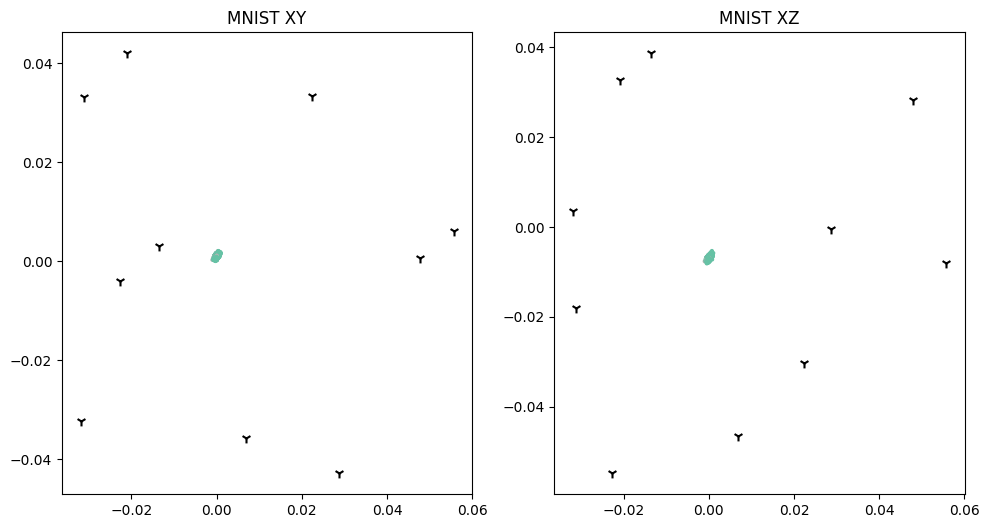

[43672] Reconstruction loss: AUC 0.4705 FZ 0.0000
[43884] Reconstruction loss: AUC 0.5114 FZ 0.0000
[44096] Reconstruction loss: AUC 0.4870 FZ 0.0000


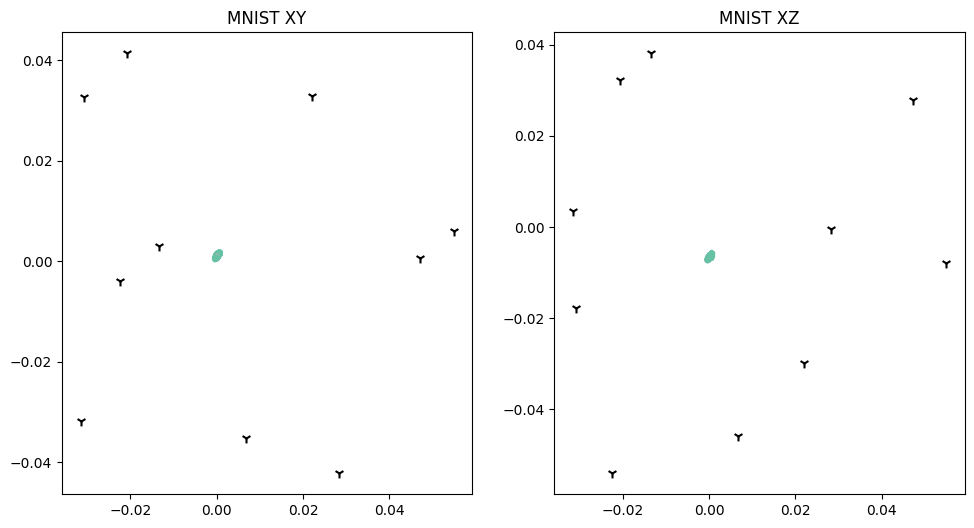

[44308] Reconstruction loss: AUC 0.5190 FZ 0.0000
[44520] Reconstruction loss: AUC 0.4849 FZ 0.0000
[44732] Reconstruction loss: AUC 0.5076 FZ 0.0000


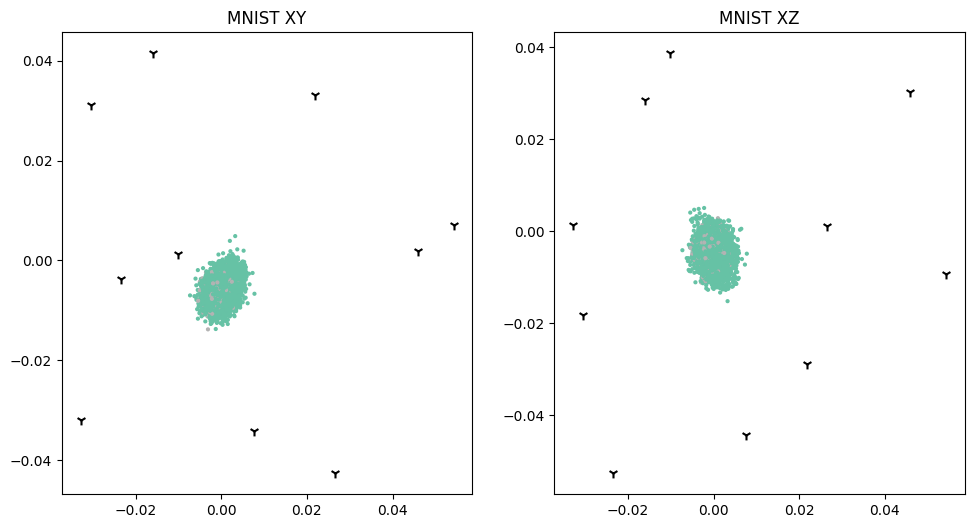

[44944] Reconstruction loss: AUC 0.5053 FZ 0.0000
[45156] Reconstruction loss: AUC 0.5051 FZ 0.0000
[45368] Reconstruction loss: AUC 0.5017 FZ 0.0000


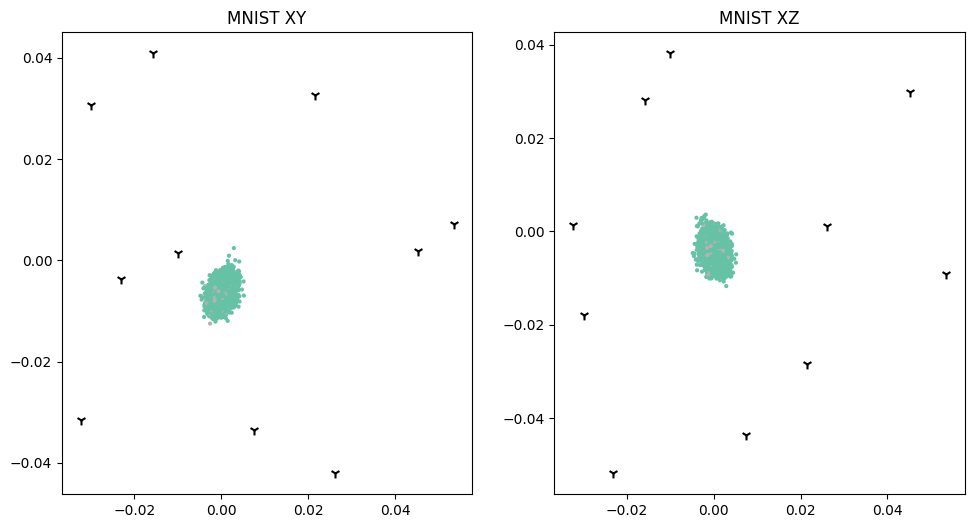

[45580] Reconstruction loss: AUC 0.5049 FZ 0.0000
[45792] Reconstruction loss: AUC 0.5111 FZ 0.0000
[46004] Reconstruction loss: AUC 0.5090 FZ 0.0000


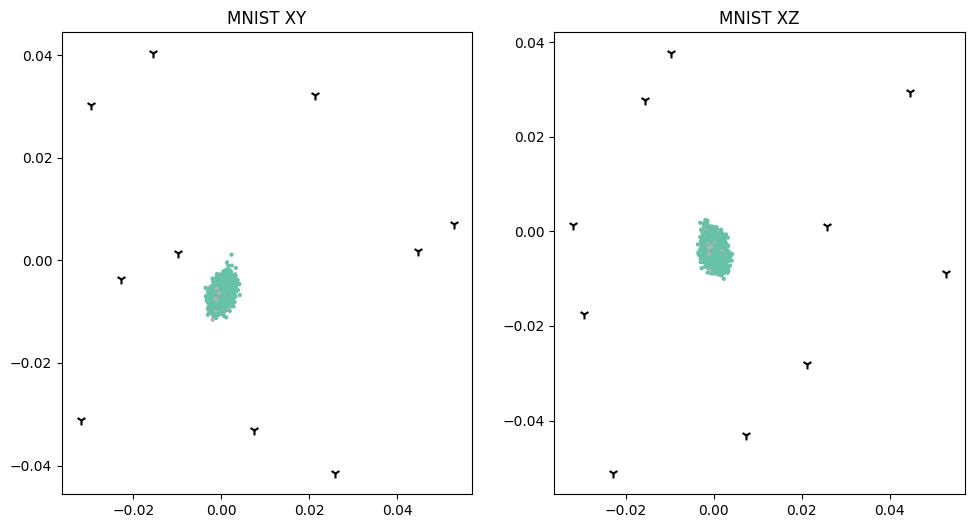

[46216] Reconstruction loss: AUC 0.5120 FZ 0.0000
[46428] Reconstruction loss: AUC 0.5109 FZ 0.0000
[46640] Reconstruction loss: AUC 0.5129 FZ 0.0000


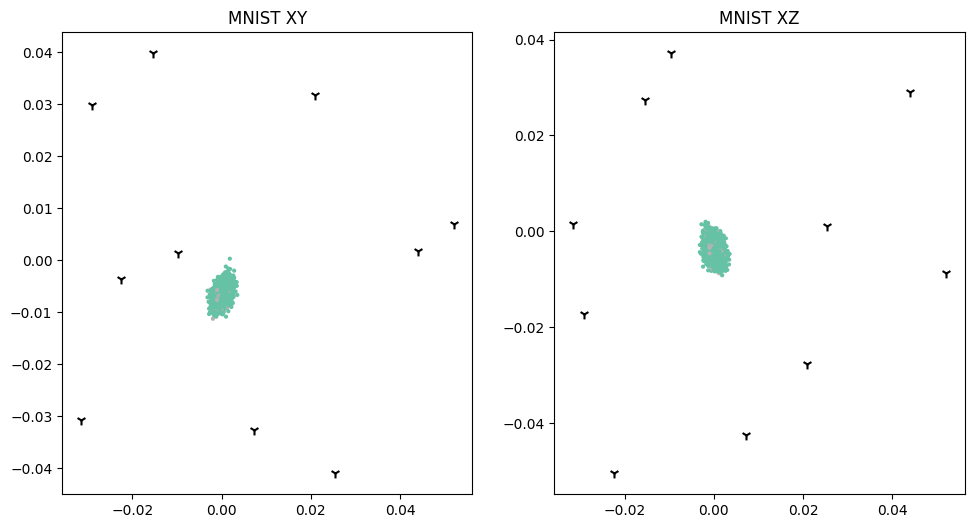

[46852] Reconstruction loss: AUC 0.5124 FZ 0.0000
[47064] Reconstruction loss: AUC 0.5214 FZ 0.0000
[47276] Reconstruction loss: AUC 0.5177 FZ 0.0000


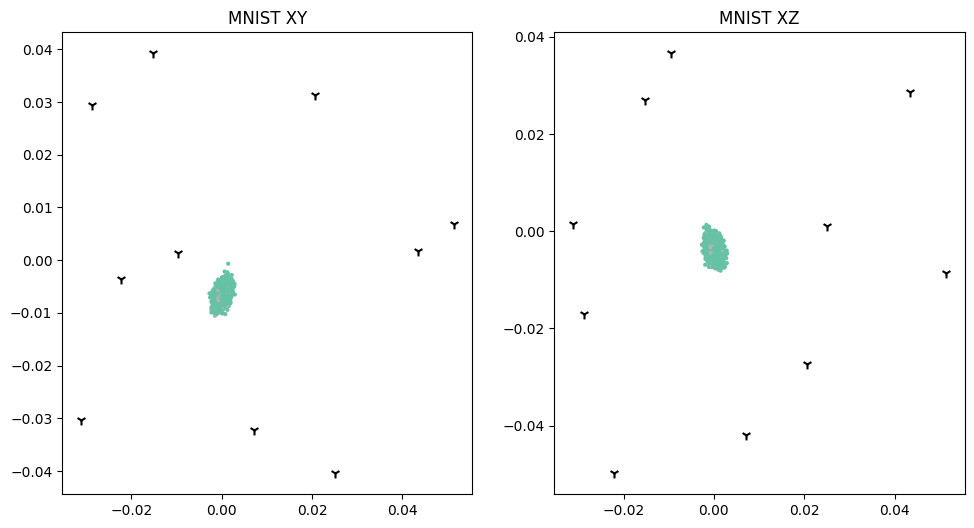

[47488] Reconstruction loss: AUC 0.5188 FZ 0.0000
[47700] Reconstruction loss: AUC 0.5187 FZ 0.0000
[47912] Reconstruction loss: AUC 0.5172 FZ 0.0000


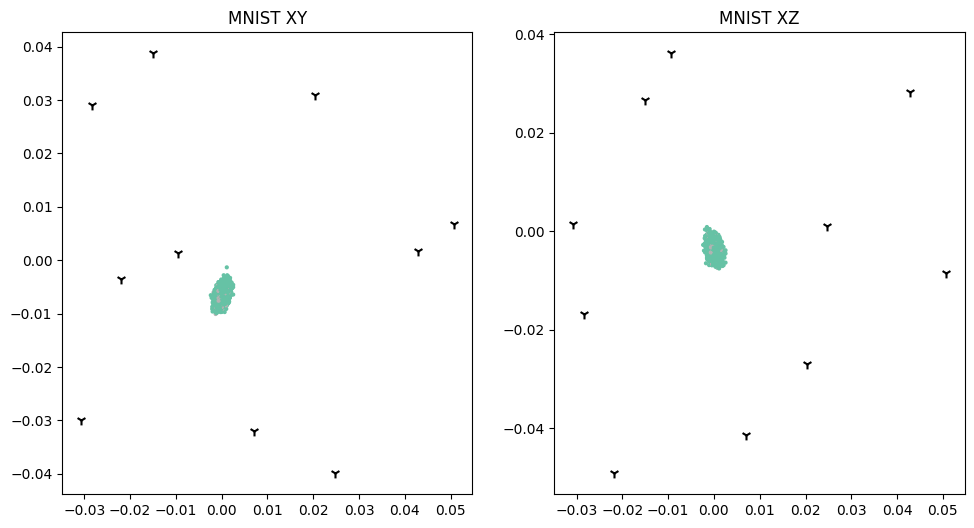

[48124] Reconstruction loss: AUC 0.5206 FZ 0.0000
[48336] Reconstruction loss: AUC 0.5154 FZ 0.0000
[48548] Reconstruction loss: AUC 0.5183 FZ 0.0000


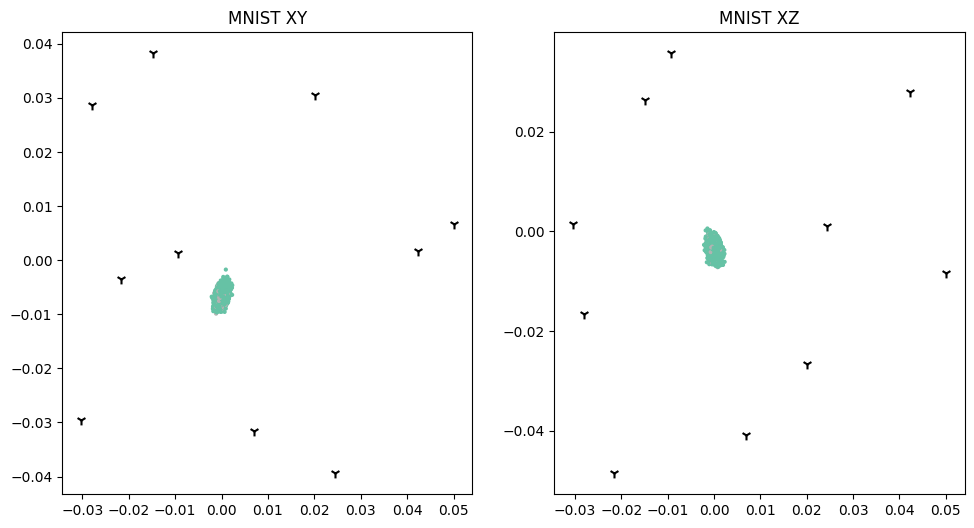

[48760] Reconstruction loss: AUC 0.5138 FZ 0.0000
[48972] Reconstruction loss: AUC 0.5176 FZ 0.0000
[49184] Reconstruction loss: AUC 0.5145 FZ 0.0000


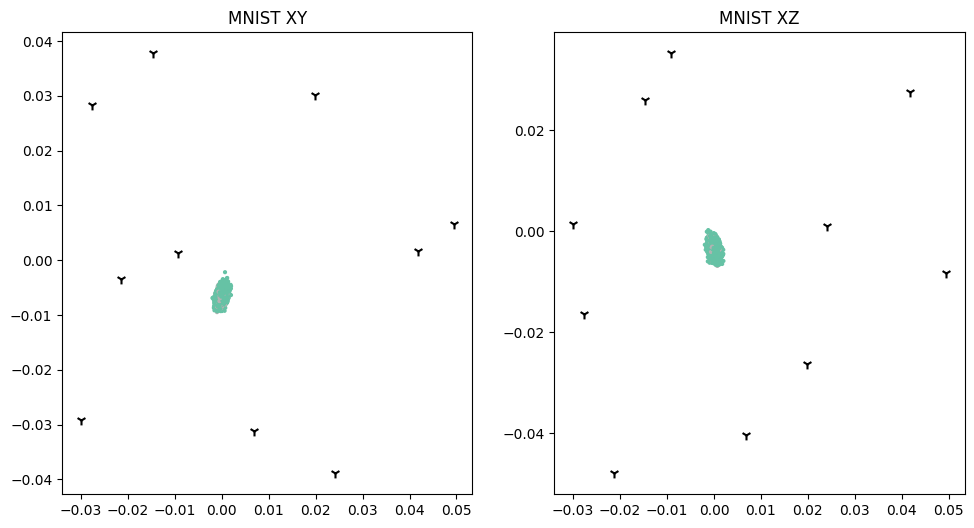

[49396] Reconstruction loss: AUC 0.5159 FZ 0.0000
[49608] Reconstruction loss: AUC 0.5099 FZ 0.0000
[49820] Reconstruction loss: AUC 0.5107 FZ 0.0000


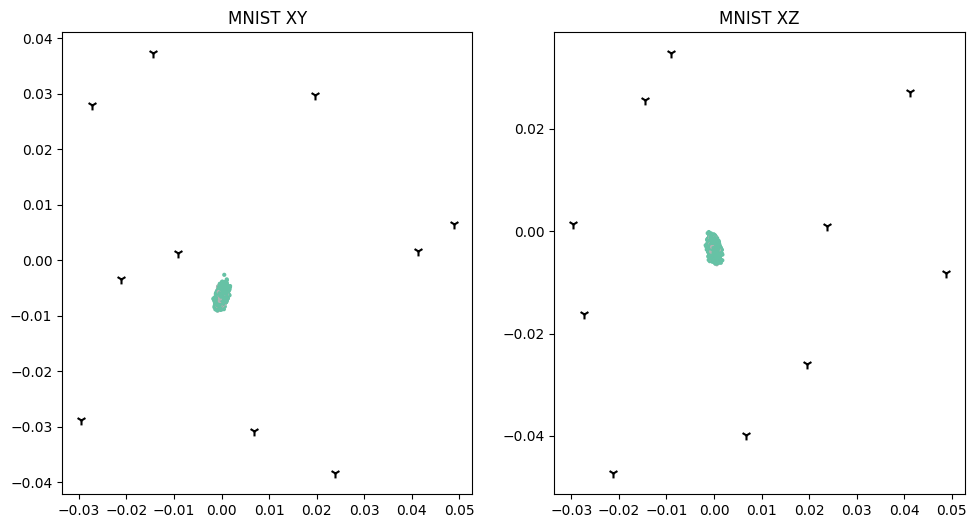

[50032] Reconstruction loss: AUC 0.5134 FZ 0.0000
[50244] Reconstruction loss: AUC 0.5111 FZ 0.0000
[50456] Reconstruction loss: AUC 0.5099 FZ 0.0000


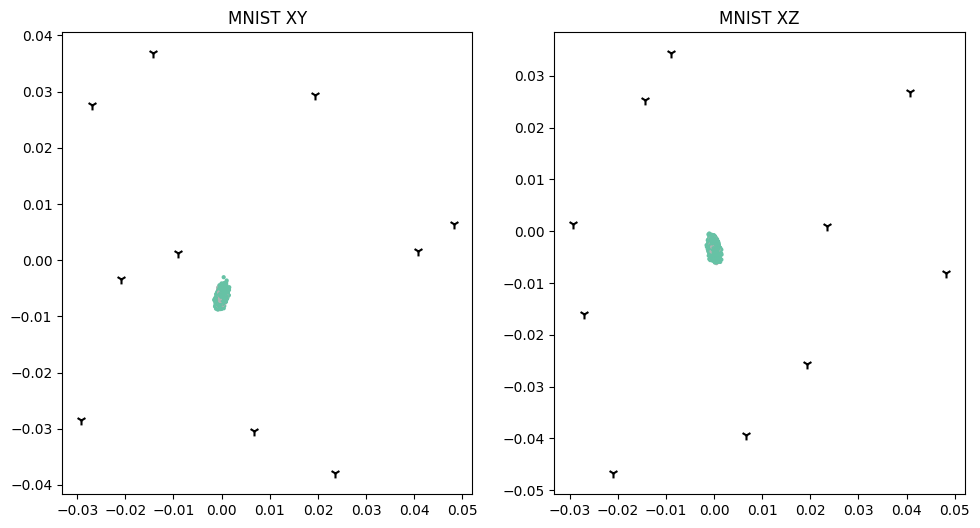

[50668] Reconstruction loss: AUC 0.5156 FZ 0.0000
[50880] Reconstruction loss: AUC 0.5102 FZ 0.0000
[51092] Reconstruction loss: AUC 0.5098 FZ 0.0000


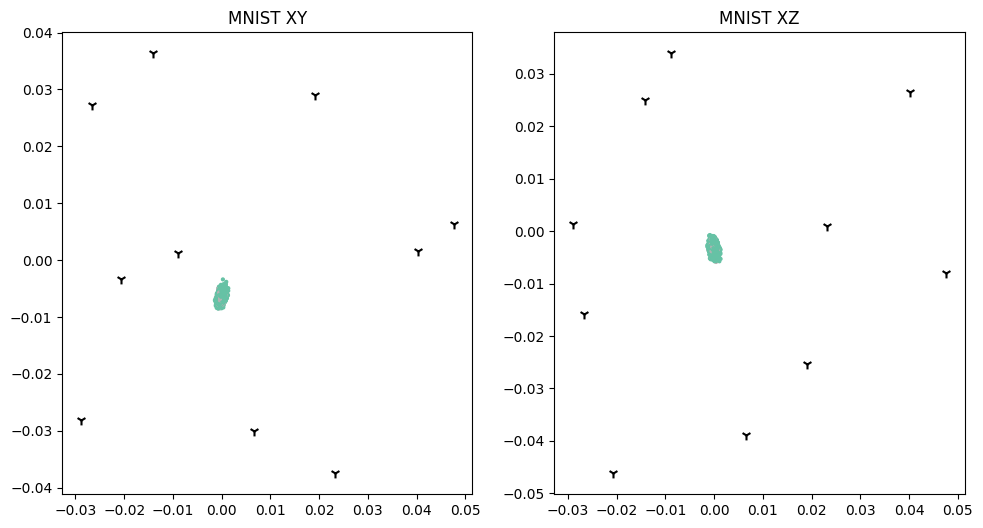

[51304] Reconstruction loss: AUC 0.5125 FZ 0.0000
[51516] Reconstruction loss: AUC 0.5121 FZ 0.0000
[51728] Reconstruction loss: AUC 0.5121 FZ 0.0000


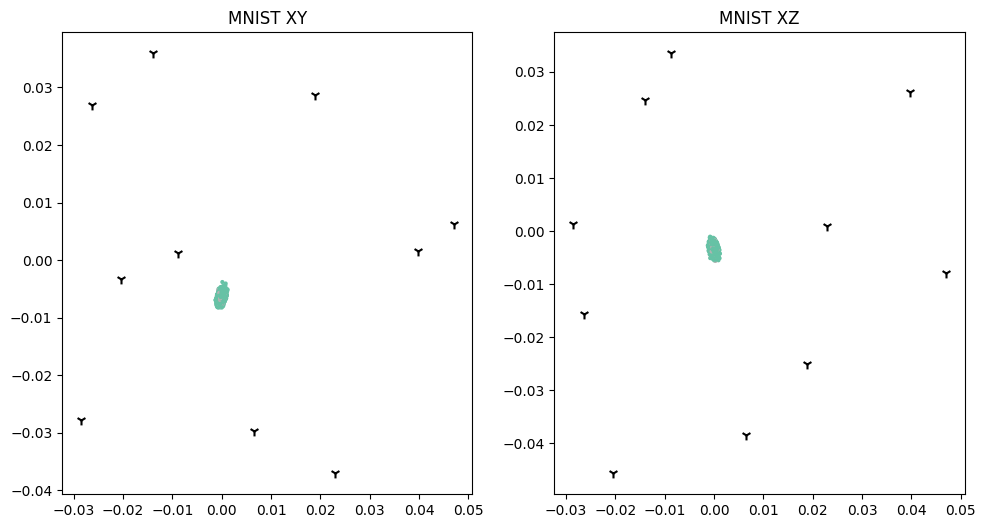

[51940] Reconstruction loss: AUC 0.5145 FZ 0.0000
[52152] Reconstruction loss: AUC 0.4955 FZ 0.0000
[52364] Reconstruction loss: AUC 0.5069 FZ 0.0000


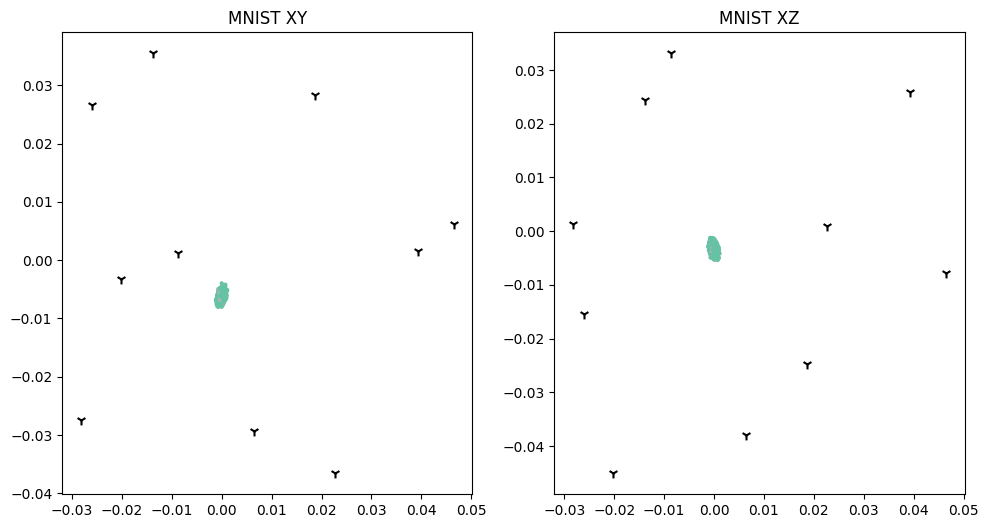

[52576] Reconstruction loss: AUC 0.5115 FZ 0.0000
[52788] Reconstruction loss: AUC 0.5123 FZ 0.0000
[53000] Reconstruction loss: AUC 0.5140 FZ 0.0000


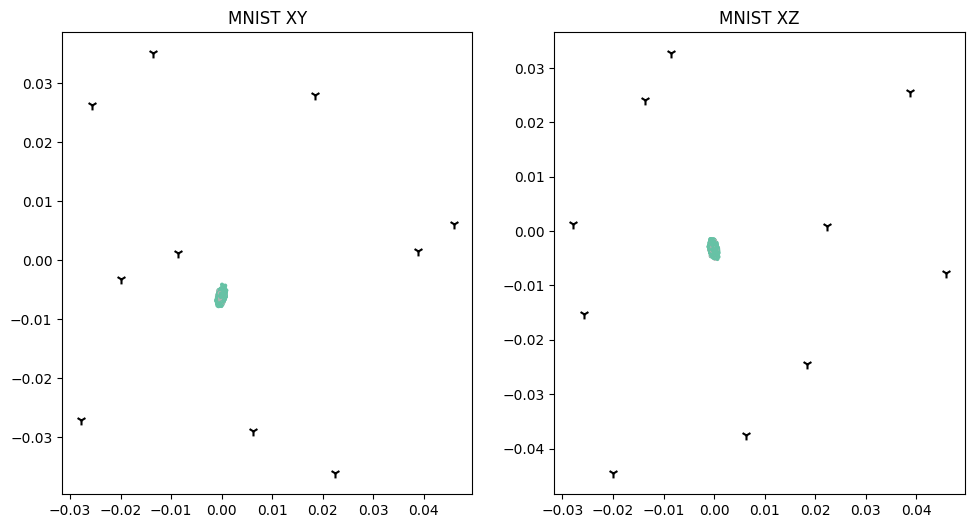

[53212] Reconstruction loss: AUC 0.5088 FZ 0.0000
[53424] Reconstruction loss: AUC 0.5094 FZ 0.0000
[53636] Reconstruction loss: AUC 0.5135 FZ 0.0000


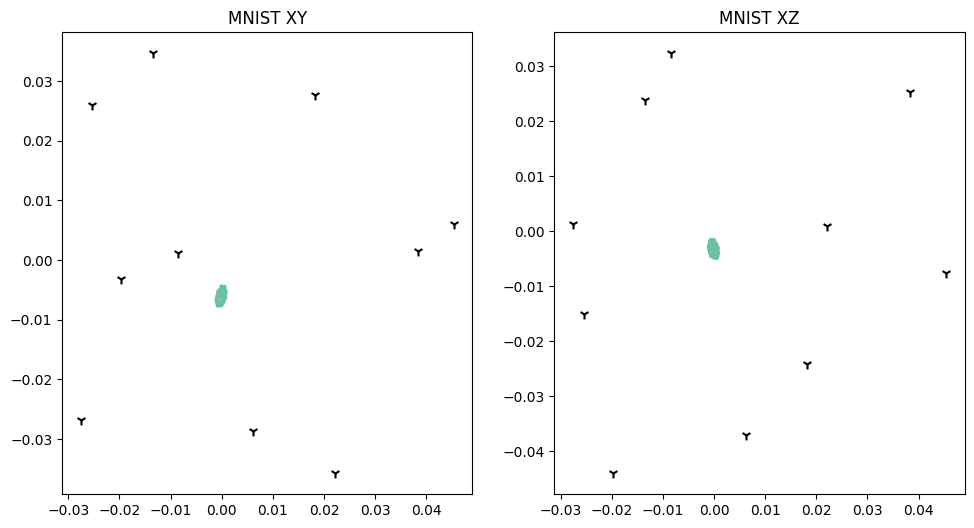

[53848] Reconstruction loss: AUC 0.5091 FZ 0.0000
[54060] Reconstruction loss: AUC 0.5185 FZ 0.0000
[54272] Reconstruction loss: AUC 0.5061 FZ 0.0000


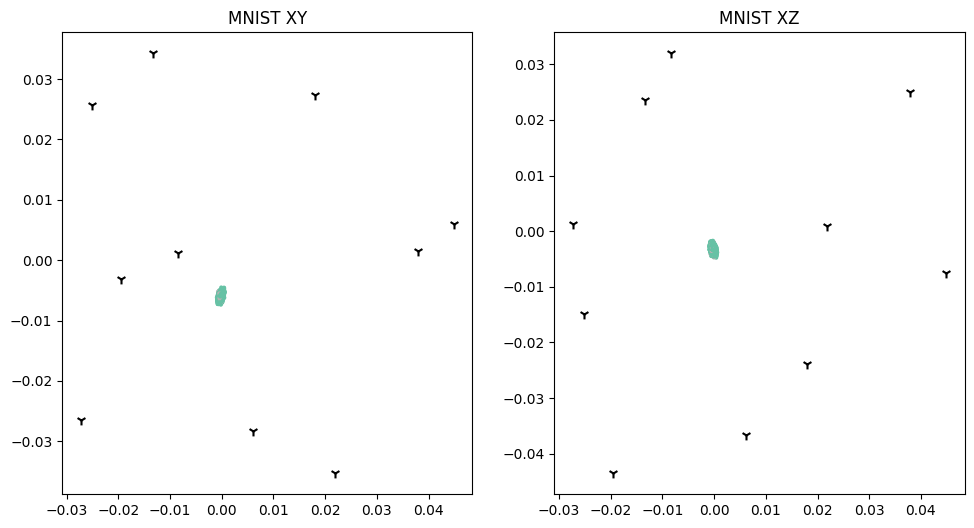

[54484] Reconstruction loss: AUC 0.5196 FZ 0.0000
[54696] Reconstruction loss: AUC 0.5050 FZ 0.0000
[54908] Reconstruction loss: AUC 0.4994 FZ 0.0000


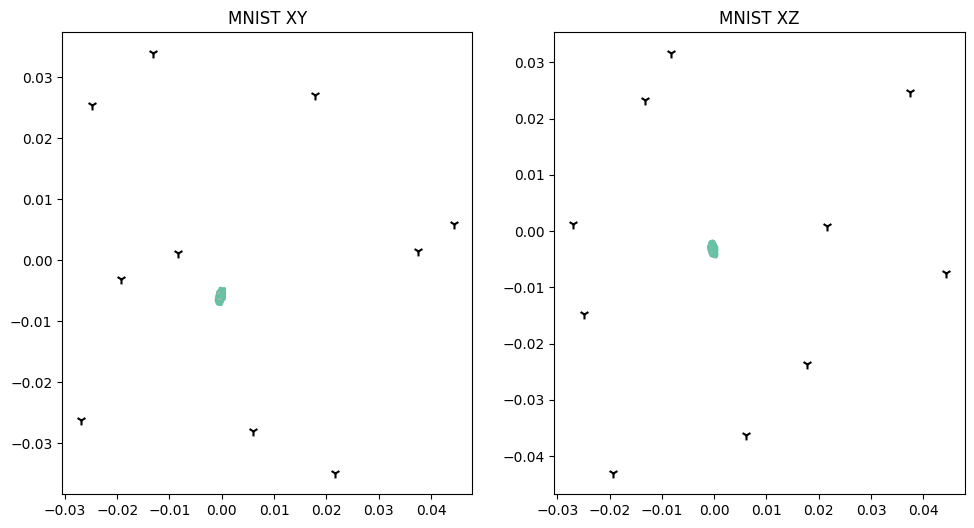

[55120] Reconstruction loss: AUC 0.5353 FZ 0.0000
[55332] Reconstruction loss: AUC 0.5106 FZ 0.0000
[55544] Reconstruction loss: AUC 0.5201 FZ 0.0000


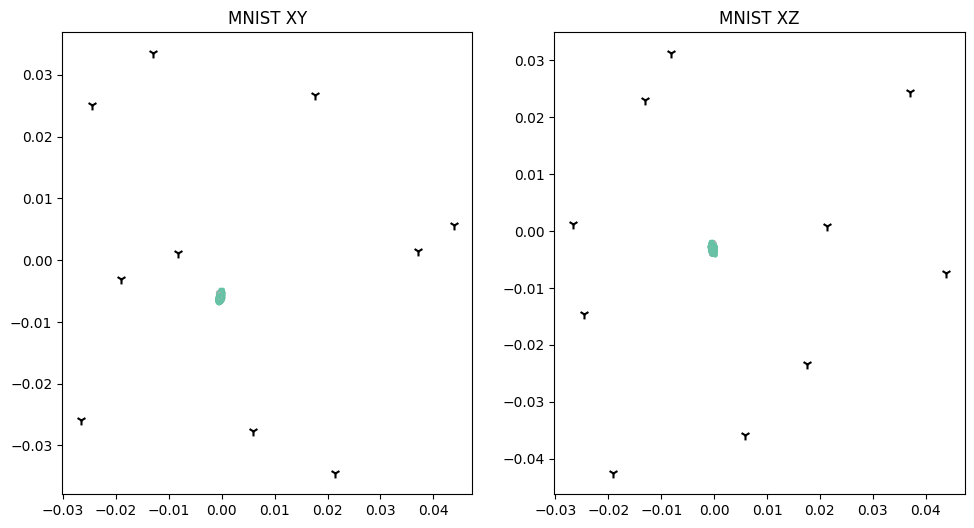

[55756] Reconstruction loss: AUC 0.5591 FZ 0.0000
[55968] Reconstruction loss: AUC 0.5148 FZ 0.0000
[56180] Reconstruction loss: AUC 0.5063 FZ 0.0000


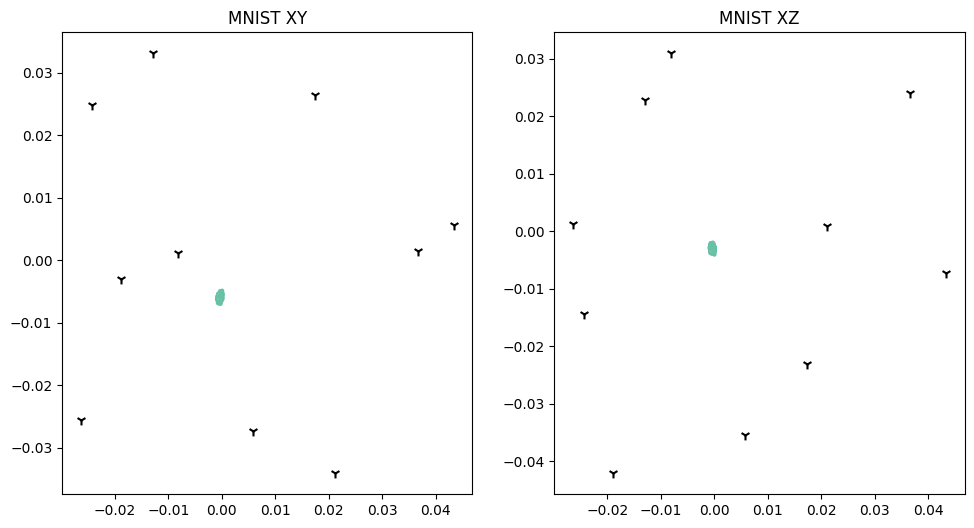

[56392] Reconstruction loss: AUC 0.5229 FZ 0.0000
[56604] Reconstruction loss: AUC 0.5182 FZ 0.0000
[56816] Reconstruction loss: AUC 0.5343 FZ 0.0000


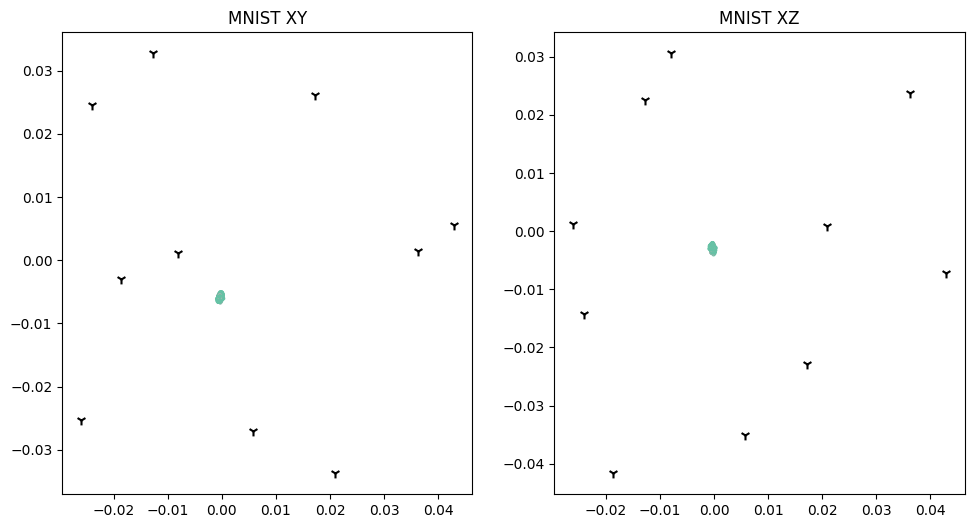

[57028] Reconstruction loss: AUC 0.5680 FZ 0.0000
[57240] Reconstruction loss: AUC 0.4699 FZ 0.0000
[57452] Reconstruction loss: AUC 0.4675 FZ 0.0000


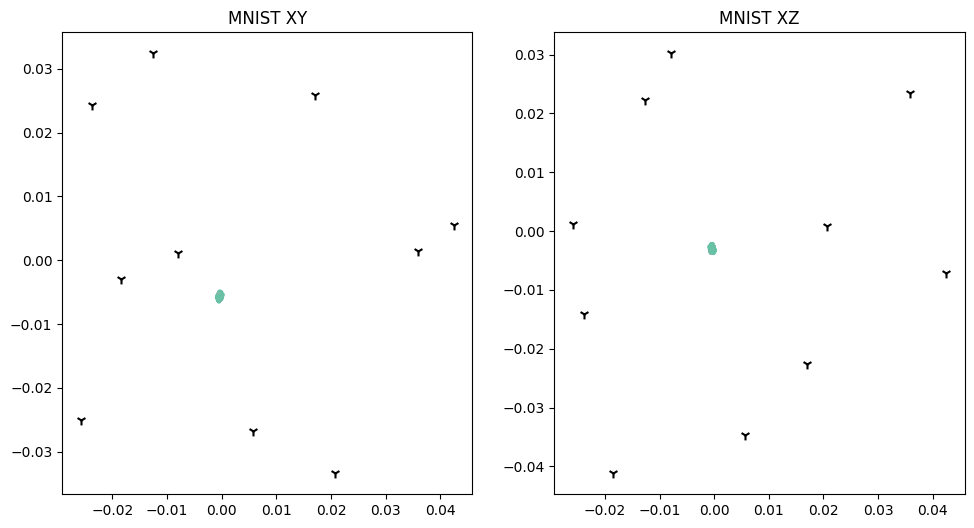

[57664] Reconstruction loss: AUC 0.4512 FZ 0.0000
[57876] Reconstruction loss: AUC 0.5398 FZ 0.0000
[58088] Reconstruction loss: AUC 0.4754 FZ 0.0000


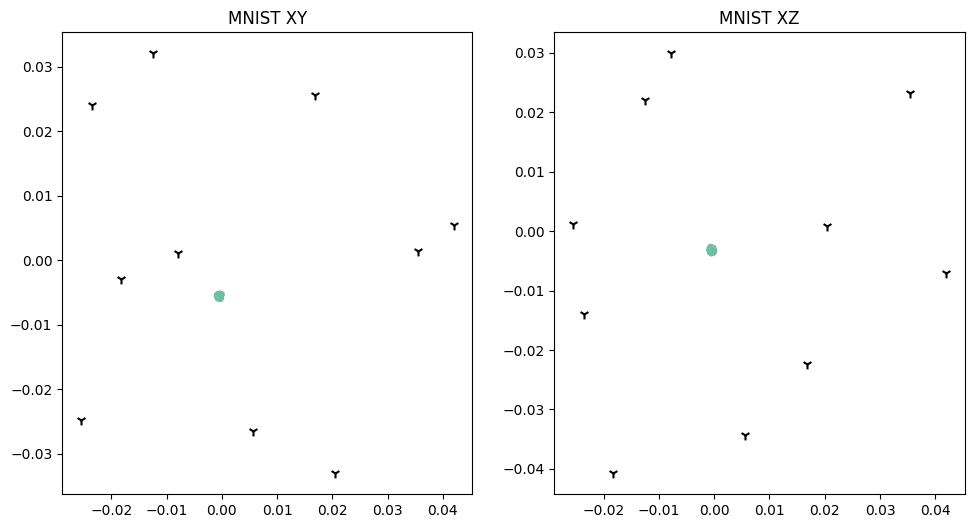

[58300] Reconstruction loss: AUC 0.5247 FZ 0.0000
[58512] Reconstruction loss: AUC 0.4416 FZ 0.0000
[58724] Reconstruction loss: AUC 0.4703 FZ 0.0000


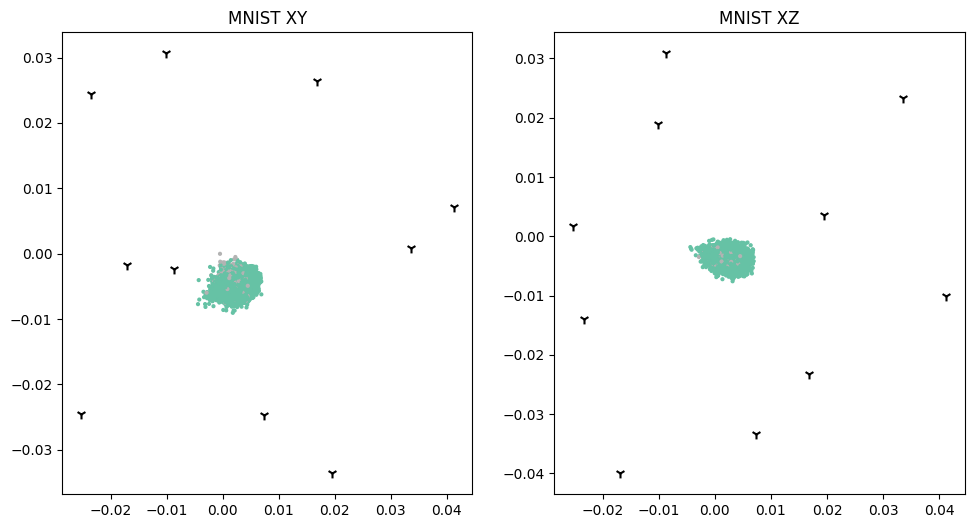

[58936] Reconstruction loss: AUC 0.4484 FZ 0.0000
[59148] Reconstruction loss: AUC 0.4456 FZ 0.0000
[59360] Reconstruction loss: AUC 0.4388 FZ 0.0000


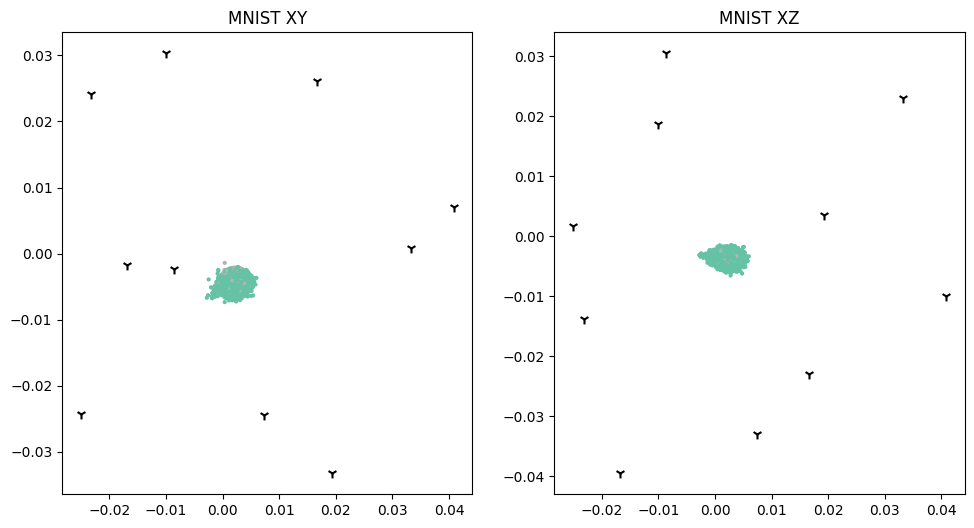

[59572] Reconstruction loss: AUC 0.4453 FZ 0.0000
[59784] Reconstruction loss: AUC 0.4447 FZ 0.0000
[59996] Reconstruction loss: AUC 0.4432 FZ 0.0000


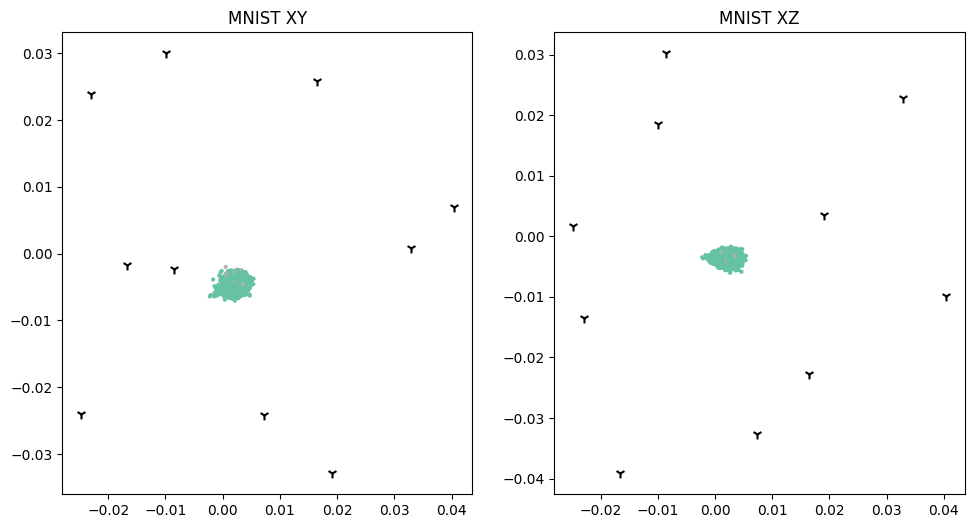

[60208] Reconstruction loss: AUC 0.4316 FZ 0.0000
[60420] Reconstruction loss: AUC 0.4314 FZ 0.0000
[60632] Reconstruction loss: AUC 0.4371 FZ 0.0000


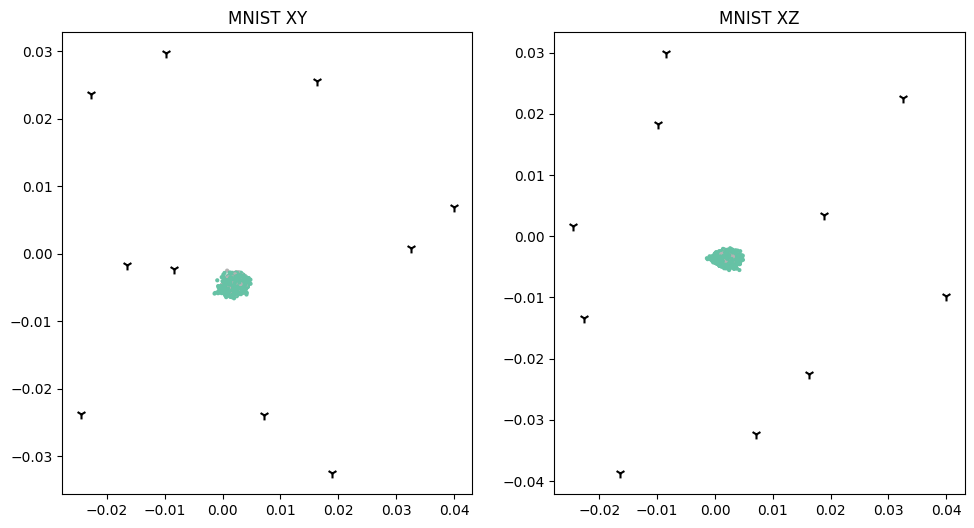

[60844] Reconstruction loss: AUC 0.4340 FZ 0.0000
[61056] Reconstruction loss: AUC 0.4303 FZ 0.0000
[61268] Reconstruction loss: AUC 0.4331 FZ 0.0000


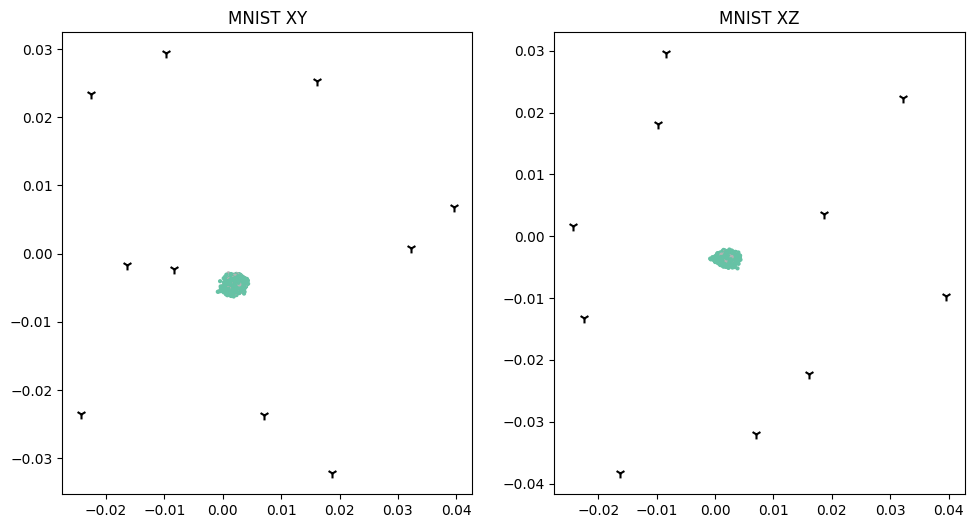

[61480] Reconstruction loss: AUC 0.4323 FZ 0.0000
[61692] Reconstruction loss: AUC 0.4362 FZ 0.0000
[61904] Reconstruction loss: AUC 0.4344 FZ 0.0000


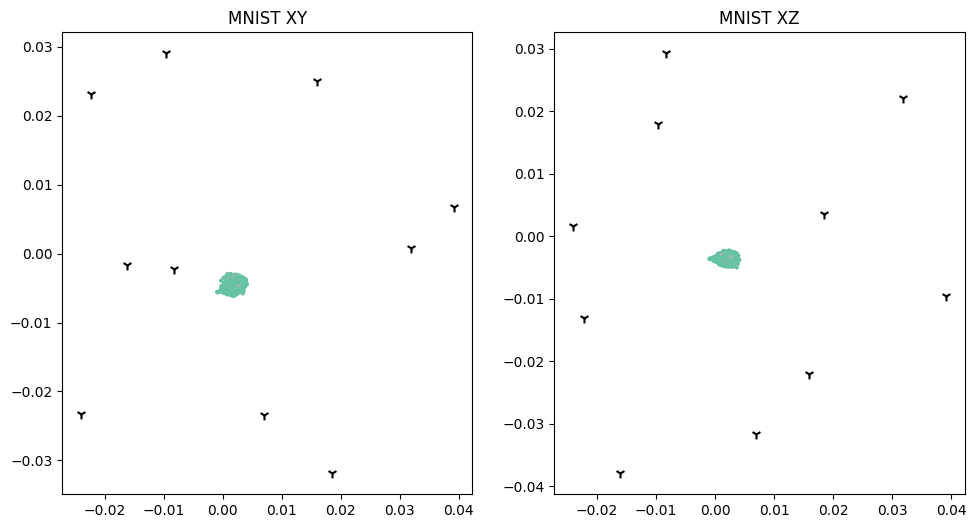

[62116] Reconstruction loss: AUC 0.4324 FZ 0.0000
[62328] Reconstruction loss: AUC 0.4365 FZ 0.0000
[62540] Reconstruction loss: AUC 0.4370 FZ 0.0000


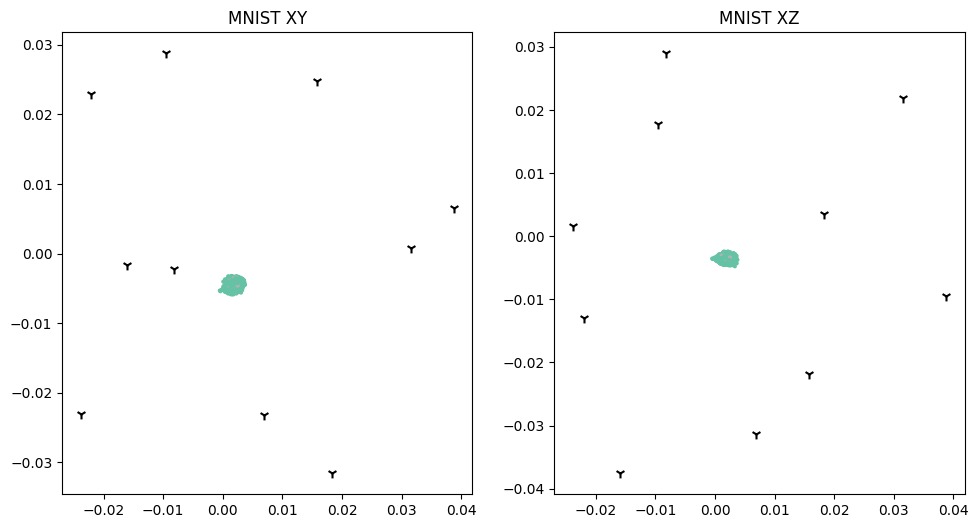

[62752] Reconstruction loss: AUC 0.4375 FZ 0.0000
[62964] Reconstruction loss: AUC 0.4410 FZ 0.0000
[63176] Reconstruction loss: AUC 0.4377 FZ 0.0000


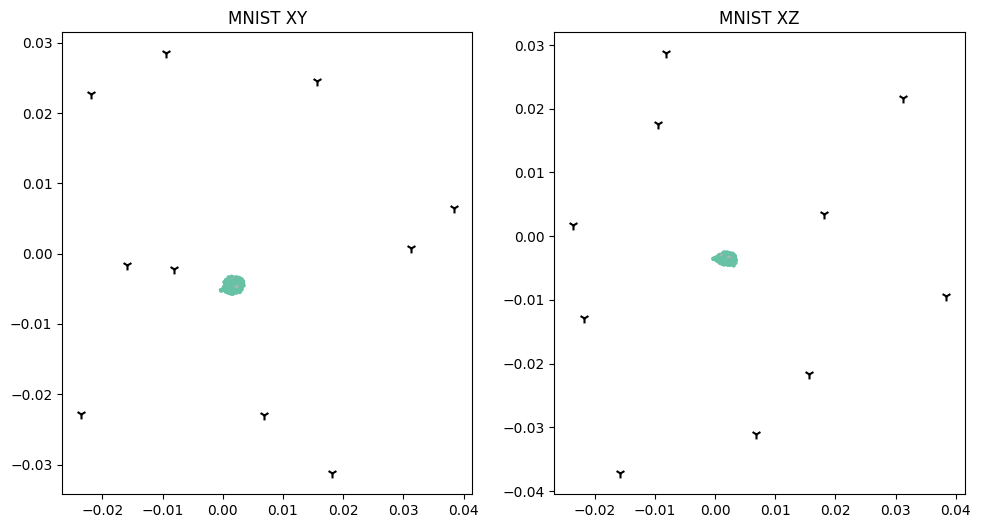

[63388] Reconstruction loss: AUC 0.4387 FZ 0.0000
[63600] Reconstruction loss: AUC 0.4391 FZ 0.0000


In [20]:
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, None, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    #scheduler.step()

In [21]:
model.fuzzy[0].get_transformation_matrix_eigenvals()

tensor([[65.5618+0.j, 63.2989+0.j, 64.3743+0.j],
        [63.4813+0.j, 65.1872+0.j, 64.5655+0.j],
        [65.1478+0.j, 64.3851+0.j, 63.6928+0.j],
        [64.6776+0.j, 64.1413+0.j, 64.3644+0.j],
        [62.7009+0.j, 64.7663+0.j, 65.7616+0.j],
        [62.6188+0.j, 66.1053+0.j, 64.5039+0.j],
        [65.5960+0.j, 63.6454+0.j, 63.9884+0.j],
        [65.0424+0.j, 63.8632+0.j, 64.3465+0.j],
        [63.7670+0.j, 64.9909+0.j, 64.4726+0.j],
        [66.0563+0.j, 63.2126+0.j, 63.9582+0.j]], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)

In [22]:
keep_eigenvals_positive_loss(model.fuzzy[0])

tensor(-1.0000e-15, device='cuda:0', grad_fn=<NegBackward0>)

## Визуализируем результаты

In [23]:

def get_activation_stats(model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, _) in enumerate(tqdm(dataloader)):
            data = data.to(device)
            _, fz = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind in act_fz:
                rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat

train_stat = get_activation_stats(model, train_loader)
test_stat = get_activation_stats(model, test_loader)

plt.bar(list(train_stat.keys()), train_stat.values(), 0.5, color='g')
plt.bar(list(test_stat.keys()), test_stat.values(), 0.5, color='r')

  0%|          | 0/212 [00:00<?, ?it/s]

TypeError: iteration over a 0-d array

In [ ]:

def get_activation_stats_by_digit(digit, model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, target) in enumerate(tqdm(dataloader)):
        
            data = data.to(device)
            _, fz = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind, trg in zip(act_fz, target):
                if trg == digit:
                    rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat


test_stat_by_digit = get_activation_stats_by_digit(9, model, test_loader)

plt.bar(list(test_stat_by_digit.keys()), test_stat_by_digit.values(), 0.5, color='r')
plt.xlim((-1, fuzzy_rules_count + 1))

In [ ]:
test_stat_by_digit

In [ ]:
def get_arate(inp):
    mu, fz = model.forward(inp)

    return fz.cpu().numpy() #(1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# (1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy() #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

In [ ]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

In [ ]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

In [ ]:
def show_plot():
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding'):
            data = data.view((-1,1,28,28)).to(device)
            embeding, _ = model.forward(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(target.cpu().numpy())
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("MNIST XY")
    plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
    
    plt.subplot(R, C, 2)
    plt.title("MNIST XZ")
    plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)

    
show_plot()